### Imports

In [2]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

import requests
import zipfile
import io
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

from datetime import datetime
from meteostat import Point, Daily
from pathlib import Path
import time

## Step 1: Data Collection and Preprocessing

### BTS Data for Southwest Region

In [ ]:
SOUTHWEST_STATE_AIRPORTS = {
    # Arizona
    "PHX", "TUS", "FLG", "YUM", "AZA",
    # New Mexico
    "ABQ", "SAF", "ROW", "HOB",
    # Texas
    "DFW", "DAL", "HOU", "AUS", "SAT", "ELP", "LBB", "MAF", "AMA", "CRP", "HRL", "MFE", "BRO", "TYR", "SJT", "ACT",
    # Oklahoma
    "OKC", "TUL", "LAW", "SWO", "END",
    # California
    "LAX", "SAN", "SFO", "OAK", "SJC", "BUR", "LGB", "SMF", "PSP", "SNA", "FAT", "ONT", "SBA", "BFL"
}

OUTPUT_FOLDER = "new_bts_data"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def download_bts_data(year, month):
    """Download BTS data for a specific month"""
    url = f'https://www.transtats.bts.gov/PREZIP/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    
    try:
        response = requests.get(
            url, 
            headers={'User-Agent': 'Mozilla/5.0'},
            timeout=300,
            stream=True
        )
        response.raise_for_status()
        
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            csv_file = next((name for name in z.namelist() if name.endswith('.csv')), None)
            if not csv_file:
                return (year, month, None, "No CSV in zip")
            
            with z.open(csv_file) as f:
                df = pd.read_csv(f, encoding='utf-8', low_memory=False)
            
            df = df[
                (df["Reporting_Airline"] == "WN") &
                (df["Origin"].isin(SOUTHWEST_STATE_AIRPORTS))
            ]
            
            if not df.empty:
                month_filename = os.path.join(OUTPUT_FOLDER, f"bts_wn_{year}_{month:02d}.csv")
                df.to_csv(month_filename, index=False)
                print(f"Saved {year}-{month:02d}: {len(df):,} rows to {month_filename}")
            
            return (year, month, df, None)
            
    except requests.exceptions.HTTPError as e:
        return (year, month, None, f"HTTP {e.response.status_code}")
    except Exception as e:
        return (year, month, None, str(e)[:50])

def download_years_parallel(start_year, end_year, max_workers=12):
    """Download multiple years of data with maximum parallelization"""
    months_to_download = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            current_date = datetime.now()
            if year > current_date.year or (year == current_date.year and month > current_date.month):
                continue
            months_to_download.append((year, month))
    
    total_months = len(months_to_download)
    print(f"Downloading {total_months} months ({start_year}-{end_year})")
    print(f"Using {max_workers} parallel workers\n")
    
    results = {}
    start_time = datetime.now()
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(download_bts_data, year, month): (year, month)
            for year, month in months_to_download
        }
        
        for future in as_completed(futures):
            year, month, df, error = future.result()
            if df is not None and not df.empty:
                results[(year, month)] = df
            else:
                print(f"✗ {year}-{month:02d}: {error or 'No matching rows'}")
    
    elapsed = (datetime.now() - start_time).total_seconds() / 60
    print(f"\nFinished in {elapsed:.1f} minutes")
    
    successful = [df for df in results.values() if df is not None]
    if successful:
        combined_df = pd.concat(successful, ignore_index=True)
        print(f"Combined total: {len(combined_df):,} rows")
        return combined_df
    else:
        print("No data downloaded")
        return None

def save_to_csv_fast(df, filename):
    """Save filtered DataFrame to CSV"""
    print(f"\nSaving combined dataset to {filename}...")
    start = datetime.now()
    df.to_csv(filename, index=False)
    elapsed = (datetime.now() - start).total_seconds()
    size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"Saved in {elapsed:.1f}s ({size_mb:.1f} MB)")

if __name__ == "__main__":
    START_YEAR = 2015 # 10 years worth of data
    END_YEAR = 2025
    MAX_WORKERS = 10

    combined_data = download_years_parallel(START_YEAR, END_YEAR, max_workers=MAX_WORKERS)
    
    if combined_data is not None:
        output_file = os.path.join(OUTPUT_FOLDER, f"bts_wn_southwest_combined_{START_YEAR}_{END_YEAR}.csv")
        save_to_csv_fast(combined_data, output_file)
        print(f"\nCombined file saved as {output_file} ({len(combined_data):,} rows)")
        print("\nHead of combined dataset:")
        print(combined_data.head())
    else:
        print("No data available after filtering.")

### Meteostat Weather Data

In [ ]:
SWA_AIRPORTS = {
    "DAL": (32.8471, -96.8517),
    "AUS": (30.1975, -97.6664),
    "HOU": (29.6454, -95.2789),
    "SAT": (29.5337, -98.4698),
    "ELP": (31.8070, -106.3779),
    "LBB": (33.6609, -101.8214),
    "MAF": (31.9369, -102.2016),
    "HRL": (26.2285, -97.6544),
    "LAX": (33.9425, -118.4081),
    "OAK": (37.7126, -122.2197),
    "SAN": (32.7338, -117.1933),
    "SJC": (37.3639, -121.9289),
    "SMF": (38.6950, -121.5908),
    "BUR": (34.2007, -118.3587),
    "ONT": (34.0559, -117.6009),
    "SNA": (33.6757, -117.8682),
    "MCO": (28.4312, -81.3081),
    "TPA": (27.9755, -82.5332),
    "FLL": (26.0726, -80.1527),
    "PBI": (26.6832, -80.0956),
    "RSW": (26.5362, -81.7552),
    "PNS": (30.4734, -87.1867),
    "JAX": (30.4941, -81.6879),
    "PHX": (33.4342, -112.0116),
    "TUS": (32.1161, -110.9410),
    "DEN": (39.8561, -104.6737),
    "LAS": (36.0801, -115.1522),
    "RNO": (39.4993, -119.7681),
    "MDW": (41.7868, -87.7522),
    "ATL": (33.6407, -84.4277),
    "BWI": (39.1754, -76.6684),
    "STL": (38.7487, -90.3700),
    "MCI": (39.2976, -94.7139),
    "BNA": (36.1245, -86.6782),
    "MEM": (35.0425, -89.9767),
    "ABQ": (35.0494, -106.6172),
    "OKC": (35.3931, -97.6008),
    "TUL": (36.1986, -95.8880),
    "MSY": (29.9934, -90.2580),
    "RDU": (35.8776, -78.7875),
    "CLT": (35.2140, -80.9431),
    "PHL": (39.8719, -75.2411),
    "PIT": (40.4915, -80.2328),
    "BOS": (42.3656, -71.0096),
    "BUF": (42.9405, -78.7322),
    "ALB": (42.7483, -73.8026),
    "ROC": (43.1181, -77.6721),
    "ISP": (40.7953, -73.1000),
    "CMH": (39.9973, -82.8876),
    "CLE": (41.4117, -81.8498),
    "IND": (39.7173, -86.2944),
    "MSP": (44.8848, -93.2223),
    "MKE": (42.9473, -87.8960),
    "DTW": (42.2162, -83.3554),
    "GRR": (42.8808, -85.5228),
    "SLC": (40.7884, -111.9777),
    "SEA": (47.4490, -122.3093),
    "GEG": (47.6269, -117.5331),
    "PDX": (45.5898, -122.5951),
    "ICT": (37.6528, -97.4331),
    "LIT": (34.7275, -92.2241),
    "SDF": (38.1740, -85.7368),
    "DSM": (41.5341, -93.6600),
    "OMA": (41.3025, -95.8941),
    "BHM": (33.5629, -86.7536),
    "RIC": (37.5052, -77.3191),
    "ORF": (36.8946, -76.2015),
    "BDL": (41.9389, -72.6839),
    "PVD": (41.7246, -71.4283),
    "MHT": (42.9327, -71.4350)
}

OUTPUT_DIR = Path("meteostat_daily")
OUTPUT_DIR.mkdir(exist_ok=True)

START_YEAR = 2015
END_YEAR = 2025
MAX_WORKERS = 4

def fetch_airport_daily(airport, coords):
    lat, lon = coords
    point = Point(lat, lon)
    all_data = []
    
    for year in range(START_YEAR, END_YEAR + 1):
        start = datetime(year, 1, 1)
        end = datetime(year, 12, 31)
        try:
            data = Daily(point, start, end).fetch()
            if not data.empty:
                data = data.reset_index().rename(columns = {"time": "date"})
                data['airport'] = airport
                all_data.append(data)
                print(f"Fetched {airport} {year} ({len(data)} rows)")
        except Exception as e:
            print(f"Error fetching {airport} {year}: {e}")
        time.sleep(0.05)
    
    if all_data:
        df = pd.concat(all_data)
        out_file = OUTPUT_DIR / f"{airport}.csv"
        df.to_csv(out_file, index=True)
        print(f"Saved {airport} to {out_file}")

def main():
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [executor.submit(fetch_airport_daily, airport, coords)
                   for airport, coords in SWA_AIRPORTS.items()]
        for fut in as_completed(futures):
            fut.result()

    all_files = list(OUTPUT_DIR.glob("*.csv"))
    combined = pd.concat((pd.read_csv(f, index_col=0) for f in all_files), ignore_index=True)
    combined.to_csv(OUTPUT_DIR / "weather_data.csv", index=False)
    print(f"\nAll airports combined: {len(combined)} rows")

if __name__ == "__main__":
    main()

### Joining BTS and Meteostat Data

In [ ]:
with zipfile.ZipFile("combined_data.zip") as z:
    csv_name = next(name for name in z.namelist() if name.endswith(".csv"))
    flights = pl.scan_csv(io.BytesIO(z.read(csv_name)), low_memory=True)

weather = pl.scan_csv("Meteostat_daily_2000-2025.csv", low_memory=True)

joined = flights.join(
    weather,
    how="inner",
    left_on=["Origin", "FlightDate"],
    right_on=["airport", "date"]
)

joined.sink_csv("joined_data.csv")

print("Streaming join completed successfully. File saved as 'joined_data.csv'")

### Converting to Imperial

In [3]:
df = pd.read_csv("FINAL_DATASET.csv")

# Temperature: Convert °C to °F
for col in ["tavg", "tmin", "tmax"]:
    if col in df.columns:
        df[col] = (df[col] * 9/5 + 32).round().astype("Int64")

# Precipitation & Snow: Convert mm to inches
for col in ["prcp", "snow"]:
    if col in df.columns:
        df[col] = df[col] / 25.4

# Wind Speed: Convert km/h to mph
if "wspd" in df.columns:
    df["wspd"] = df["wspd"] / 1.60934

# Pressure: Convert hPa to inHg
if "pres" in df.columns:
    df["pres"] = df["pres"] * 0.02953

print(df.head(1))

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2015        3      8           3          1  2015-08-03                WN   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     19393                          WN      N7743B  ...   

   tavg  tmin  tmax  prcp snow wdir       wspd  wpgt       pres  tsun  
0    81    71    94   0.0  0.0  NaN  10.501199   NaN  29.828253   NaN  

[1 rows x 120 columns]


### Converting Time to Cyclical

In [4]:
# Transforming departure time to cyclical
print(df['CRSDepTime'])

df['DepHour'] = df['CRSDepTime'] // 100
df['DepMinute'] = df['CRSDepTime'] % 100
df['DepTotalMinutes'] = df['DepHour'] * 60 + df['DepMinute']

df['DepTime_sin'] = np.sin(2*np.pi*df['DepTotalMinutes'] / 1440)
df['DepTime_cos'] = np.cos(2*np.pi*df['DepTotalMinutes'] / 1440)

print(df['DepTime_sin'].head())
print(df['DepTime_cos'].head())

# Same for arrival
print(df['CRSArrTime'])

df['ArrHour'] = df['CRSArrTime'] // 100
df['ArrMinute'] = df['CRSArrTime'] % 100
df['ArrTotalMinutes'] = df['ArrHour'] * 60 + df['ArrMinute']

df['ArrTime_sin'] = np.sin(2*np.pi*df['ArrTotalMinutes'] / 1440)
df['ArrTime_cos'] = np.cos(2*np.pi*df['ArrTotalMinutes'] / 1440)

print(df['ArrTime_sin'].head())
print(df['ArrTime_cos'].head())

0           630
1          1655
2          1820
3           600
4          1330
           ... 
4502068     630
4502069    1320
4502070    1350
4502071    1730
4502072     505
Name: CRSDepTime, Length: 4502073, dtype: int64
0    0.991445
1   -0.960050
2   -0.996195
3    1.000000
4   -0.382683
Name: DepTime_sin, dtype: float64
0   -1.305262e-01
1   -2.798290e-01
2    8.715574e-02
3    6.123234e-17
4   -9.238795e-01
Name: DepTime_cos, dtype: float64
0           735
1          1800
2          1925
3           705
4          1435
           ... 
4502068     650
4502069    1340
4502070    1510
4502071    1855
4502072     630
Name: CRSArrTime, Length: 4502073, dtype: int64
0    0.915311
1   -1.000000
2   -0.932008
3    0.960050
4   -0.625923
Name: ArrTime_sin, dtype: float64
0   -4.027467e-01
1   -1.836970e-16
2    3.624380e-01
3   -2.798290e-01
4   -7.798845e-01
Name: ArrTime_cos, dtype: float64


### Treating Missing Values

In [5]:
# Percentage NA by column
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False).head(75))

# Removing >95% missing cols and IATA Code column due to redundancy
cols_to_drop = percent_na[percent_na > 95].index
df = df.drop(columns = cols_to_drop)
df = df.drop(columns = ["IATA_CODE_Reporting_Airline"])

print(f"\nDropped {len(cols_to_drop)} columns")
print("Remaining columns: ", len(df.columns))

# Printing percentage again
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

Div3TotalGTime          100.000000
Div3LongestGTime        100.000000
Div5TailNum             100.000000
Div5WheelsOff           100.000000
Div5LongestGTime        100.000000
Div5TotalGTime          100.000000
Div5WheelsOn            100.000000
Div5AirportSeqID        100.000000
Div5AirportID           100.000000
Div3WheelsOff           100.000000
Div3TailNum             100.000000
Div4Airport             100.000000
Div4AirportID           100.000000
Div4AirportSeqID        100.000000
Div5Airport             100.000000
Div4WheelsOn            100.000000
Div4TotalGTime          100.000000
Div4LongestGTime        100.000000
Div4WheelsOff           100.000000
Unnamed: 109            100.000000
Div4TailNum             100.000000
Div3Airport             100.000000
Div3WheelsOn            100.000000
Div3AirportSeqID        100.000000
wdir                    100.000000
Div3AirportID           100.000000
tsun                     99.999711
Div2WheelsOff            99.999578
Div2TailNum         

### Weather Graphs

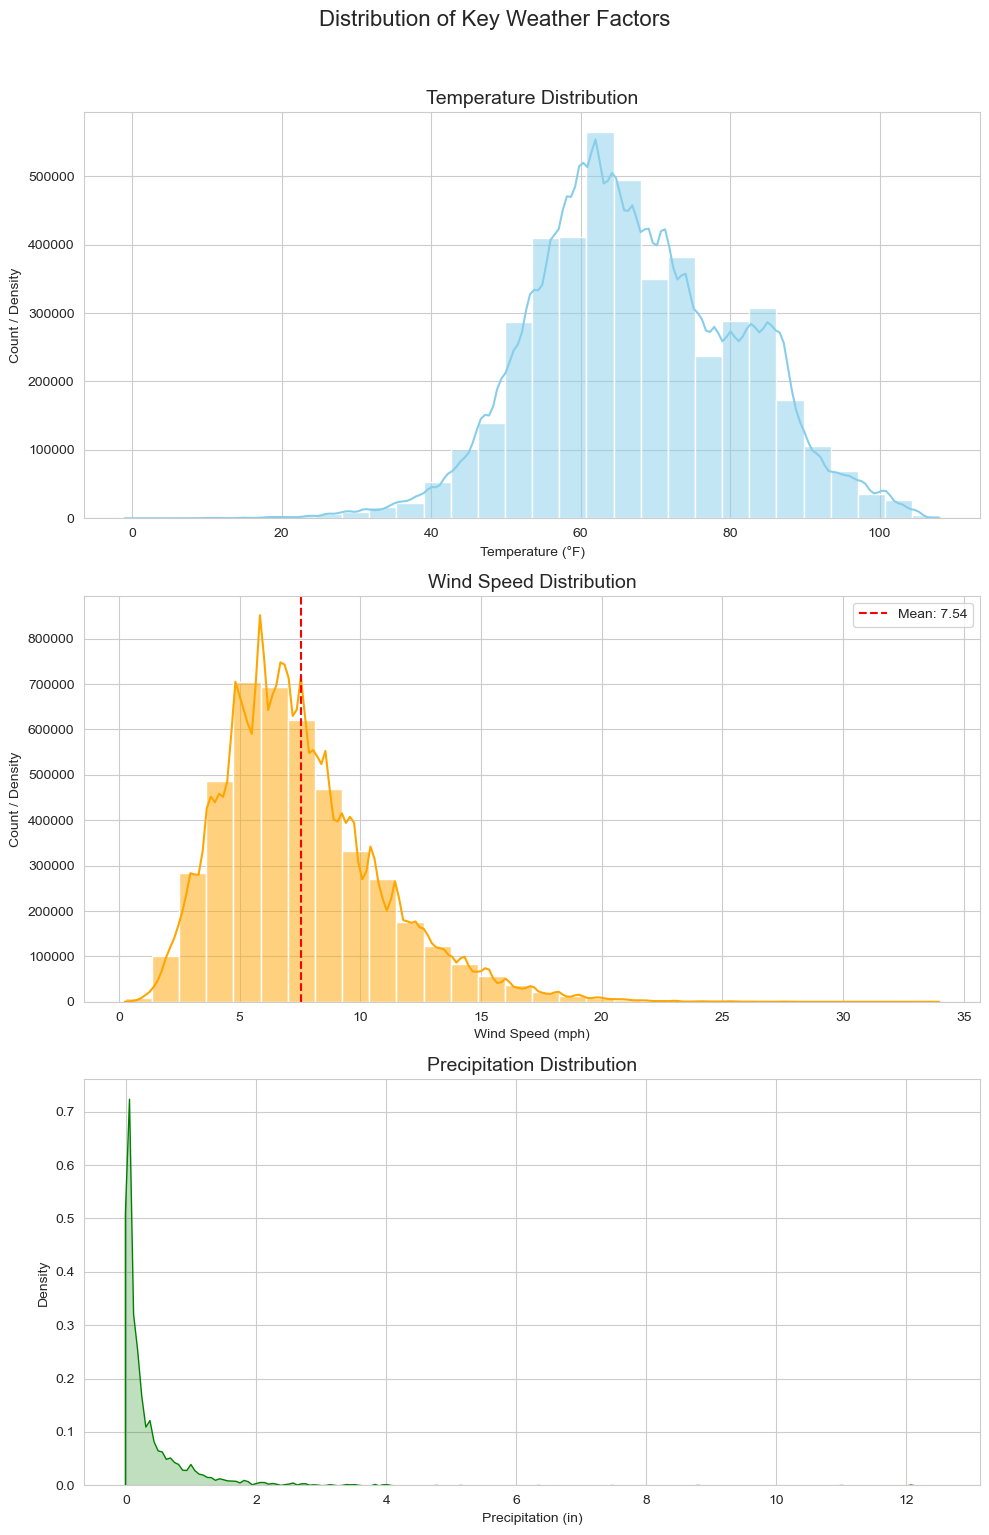

In [12]:
df['wspd'] = np.clip(df['wspd'], 0, 50) # Clip for realism
df['prcp'] = np.clip(df['prcp'], 0, 50) # Clip for realism
# Convert Snow_Presence to a descriptive category for better plotting
df['snow'] = df['snow'].map({0: 'No Snow', 1: 'Snow'})
# ----------------------------------------------------

# Set a style for better visualization
sns.set_style("whitegrid")

## 📊 Plotting Continuous Variables (Temperature, Wind Speed, Precipitation)

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.suptitle('Distribution of Key Weather Factors', fontsize=16, y=1.02)

# --- 1. Temperature Distribution (Histogram with KDE) ---
sns.histplot(df['tavg'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Temperature Distribution', fontsize=14)
axes[0].set_xlabel('Temperature (°F)')
axes[0].set_ylabel('Count / Density')
# 

# --- 2. Wind Speed Distribution (Histogram with KDE) ---
sns.histplot(df['wspd'], bins=30, kde=True, color='orange', ax=axes[1])
axes[1].set_title('Wind Speed Distribution', fontsize=14)
axes[1].set_xlabel('Wind Speed (mph)')
axes[1].set_ylabel('Count / Density')
# Add a vertical line for the mean to highlight the average condition
axes[1].axvline(df['wspd'].mean(), color='r', linestyle='--', label=f"Mean: {df['wspd'].mean():.2f}")
axes[1].legend()

# --- 3. Precipitation Distribution (KDE Plot for Skewed Data) ---
# A KDE plot is often better for highly skewed data like precipitation, 
# where many values are zero or near-zero.
sns.kdeplot(df['prcp'], fill=True, color='green', ax=axes[2], 
            bw_adjust=0.5) # bw_adjust controls smoothness
axes[2].set_title('Precipitation Distribution', fontsize=14)
axes[2].set_xlabel('Precipitation (in)')
axes[2].set_ylabel('Density')


plt.tight_layout()
plt.show()

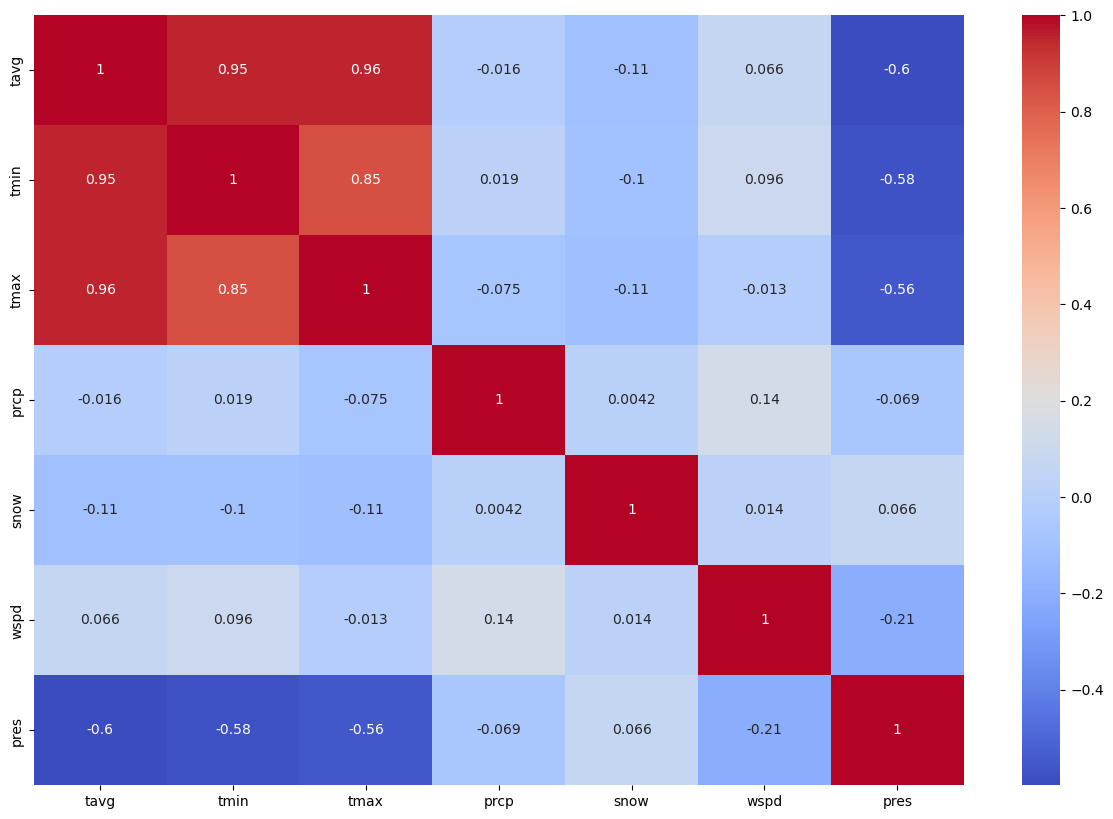

In [12]:
weather_df = df[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres']]
plt.figure(figsize = (15, 10))
sns.heatmap(weather_df.corr(), annot = True, cmap = "coolwarm")
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



ValueError: Axis limits cannot be NaN or Inf

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


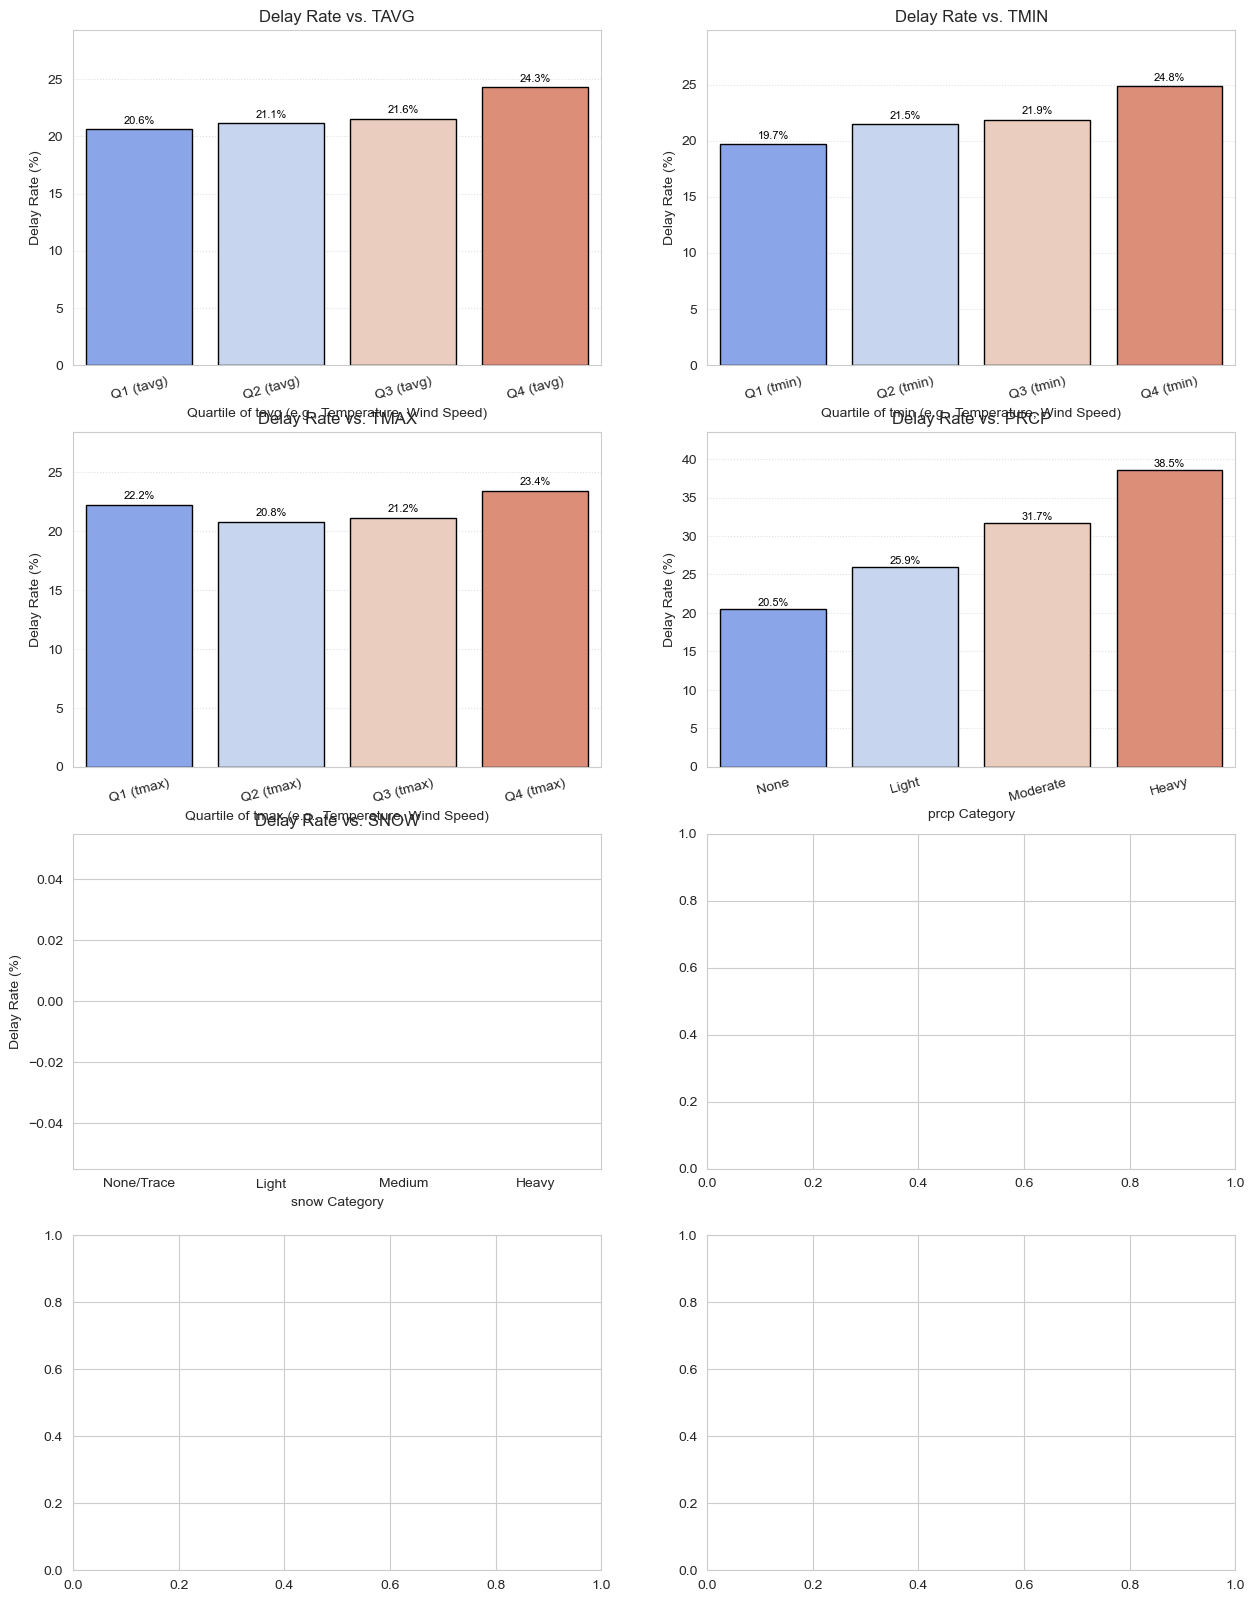

In [28]:
weather_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres']
n_cols = len(weather_cols)
fig, axes = plt.subplots(
    nrows=(n_cols + 1) // 2, 
    ncols=2, 
    figsize=(15, 5 * ((n_cols + 1) // 2))
)

axes = axes.flatten()

for i, col in enumerate(weather_cols):
    # 1. Create Bins (Categories) for the continuous variable
    
    # Use qcut to create 4 bins with roughly equal number of flights in each (quartiles)
    if col in ['tavg', 'tmin', 'tmax', 'wspd', 'pres']:
        df[f'{col}_Category'] = pd.qcut(df[col], q=4, labels=[f'Q1 ({col})', f'Q2 ({col})', f'Q3 ({col})', f'Q4 ({col})'])
        x_label = f'Quartile of {col} (e.g., Temperature, Wind Speed)'
    # Special handling for precipitation (prcp) and snow, as they often have many zeros
    elif col in ['prcp', 'snow']:
        # Create simple categories: Zero, Low, Medium, High
        if col == 'prcp':
            bins = [-np.inf, 0.01, 0.2, 1.0, np.inf]
            labels = ['None', 'Light', 'Moderate', 'Heavy']
        else: # snow
            bins = [-np.inf, 0.1, 1.0, 5.0, np.inf]
            labels = ['None/Trace', 'Light', 'Medium', 'Heavy']
            
        df[f'{col}_Category'] = pd.cut(df[col], bins=bins, labels=labels, right=True)
        x_label = f'{col} Category'

    # 2. Calculate the delay rate (mean of DepDel15) for each new category
    delay_summary = df.groupby(f'{col}_Category')['DepDel15'].mean().reset_index()
    delay_summary['Delay_Rate_Pct'] = delay_summary['DepDel15'] * 100
    
    # 3. Plot the result
    sns.barplot(
        x=f'{col}_Category', 
        y='Delay_Rate_Pct', 
        data=delay_summary, 
        ax=axes[i], 
        palette='coolwarm',
        edgecolor='black'
    )
    
    # Add values on top of the bars
    for index, row in delay_summary.iterrows():
        axes[i].text(row.name, row['Delay_Rate_Pct'] + 0.5, f"{row['Delay_Rate_Pct']:.1f}%", 
                        color='black', ha="center", fontsize=8)
    
    axes[i].set_title(f'Delay Rate vs. {col.upper()}', fontsize=12)
    axes[i].set_xlabel(x_label, fontsize=10)
    axes[i].set_ylabel('Delay Rate (%)', fontsize=10)
    axes[i].set_ylim(0, delay_summary['Delay_Rate_Pct'].max() + 5)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].grid(axis='y', linestyle=':', alpha=0.6)

# Hide any unused subplots
for i in range(n_cols, len(axes)):
    fig.delaxes(axes[i])
    
fig.suptitle('Impact of Individual Weather Factors', fontsize=16, fontweight='bold', y=1.02)
plt.subplots_adjust(bottom=1, right=0.8, top=1)
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



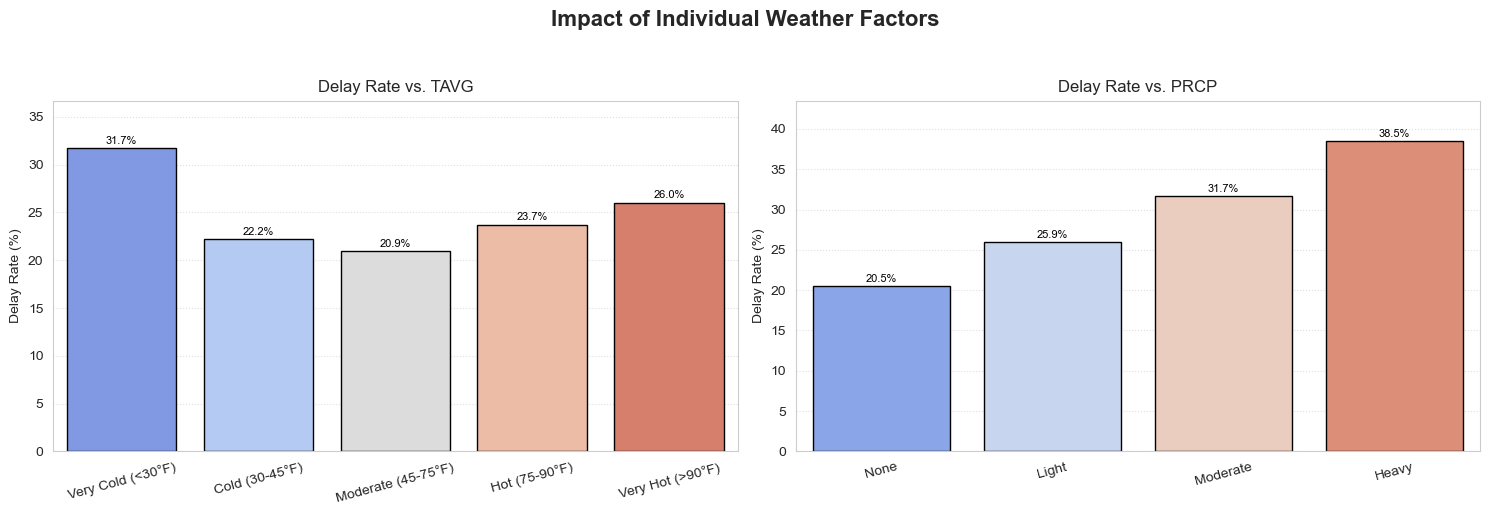

In [36]:
delay_col='DepDel15'
weather_cols=['tavg', 'prcp']
# Calculate the number of subplots needed
n_cols = len(weather_cols)
# Determine the number of rows based on the number of factors (2 plots per row)
nrows = (n_cols + 1) // 2 
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=2, 
    figsize=(15, 5 * nrows)
)

axes = axes.flatten()

for i, col in enumerate(weather_cols):
    
    # 1. Create Bins (Categories) for the continuous variable based on the factor
    
    if col in ['tavg', 'tmin', 'tmax']:
        # Custom bins for Temperature to capture cold and hot extremes (bimodal impact)
        bins = [-np.inf, 30, 45, 75, 90, np.inf]
        labels = ['Very Cold (<30°F)', 'Cold (30-45°F)', 'Moderate (45-75°F)', 'Hot (75-90°F)', 'Very Hot (>90°F)']
        # x_label = f'{col.upper()} Range (°F)'
        x_label = ''
        df[f'{col}_Category'] = pd.cut(df[col], bins=bins, labels=labels, right=True)

    elif col == 'wspd':
        # Custom bins for Wind Speed to capture critical thresholds (nonlinear impact)
        bins = [-np.inf, 10, 20, 30, np.inf]
        labels = ['Low (<10 mph)', 'Medium (10-20 mph)', 'High (20-30 mph)', 'Severe (>30 mph)']
        # x_label = 'Wind Speed Range (MPH)'
        df[f'{col}_Category'] = pd.cut(df[col], bins=bins, labels=labels, right=True)


    # 2. Calculate the delay rate (mean of DepDel15) for each new category
    category_col = f'{col}_Category'
    delay_summary = df.groupby(category_col)[delay_col].mean().reset_index()
    delay_summary['Delay_Rate_Pct'] = delay_summary[delay_col] * 100
    
    # 3. Plot the result
    sns.barplot(
        x=category_col, 
        y='Delay_Rate_Pct', 
        data=delay_summary, 
        ax=axes[i], 
        palette='coolwarm',
        edgecolor='black'
    )
    
    # Add values on top of the bars
    for index, row in delay_summary.iterrows():
        axes[i].text(row.name, row['Delay_Rate_Pct'] + 0.5, f"{row['Delay_Rate_Pct']:.1f}%", 
                        color='black', ha="center", fontsize=8)
    
    axes[i].set_title(f'Delay Rate vs. {col.upper()}', fontsize=12)
    axes[i].set_xlabel(x_label, fontsize=10)
    axes[i].set_ylabel('Delay Rate (%)', fontsize=10)
    axes[i].set_ylim(0, delay_summary['Delay_Rate_Pct'].max() + 5)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].grid(axis='y', linestyle=':', alpha=0.6)

# Hide any unused subplots
for i in range(n_cols, len(axes)):
    fig.delaxes(axes[i])
    
fig.suptitle('Impact of Individual Weather Factors', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [8]:
print(df.head())

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2015        3      8           3          1  2015-08-03                WN   
1  2015        3      8           3          1  2015-08-03                WN   
2  2015        3      8           3          1  2015-08-03                WN   
3  2015        3      8           3          1  2015-08-03                WN   
4  2015        3      8           3          1  2015-08-03                WN   

   DOT_ID_Reporting_Airline Tail_Number  Flight_Number_Reporting_Airline  \
0                     19393      N7743B                           2066.0   
1                     19393      N525SW                             51.0   
2                     19393      N528SW                             55.0   
3                     19393      N523SW                            714.0   
4                     19393      N515SW                           3740.0   

   OriginAirportID  OriginAirportSeqID  OriginCityMarketID Ori

In [11]:
df_delayed = df
df['TotalDisruptionMinutes'] = np.where(
    (df['Cancelled'] == 1.0) | (df['Diverted'] == 1.0),
    1000,
    df['DepDelayMinutes']
)

In [14]:
# 1.1 IsSevereDisruption (Total disruption flag, used for reference)
df['IsSevereDisruption'] = np.where(
    (df['Cancelled'] == 1.0) | (df['Diverted'] == 1.0) | (df['DepDel15'] == 1.0),
    1.0, 
    0.0
)

# 1.2 IsCancelledOrDiverted (The worst outcomes)
df['IsCancelledOrDiverted'] = np.where(
    (df['Cancelled'] == 1.0) | (df['Diverted'] == 1.0),
    1.0, 
    0.0
)

# 1.3 IsDelayedOnly (15+ minute delays that were NOT Cancelled/Diverted)
df['IsDelayedOnly'] = np.where(
    (df['DepDel15'] == 1.0) & (df['IsCancelledOrDiverted'] == 0.0),
    1.0, 
    0.0
)

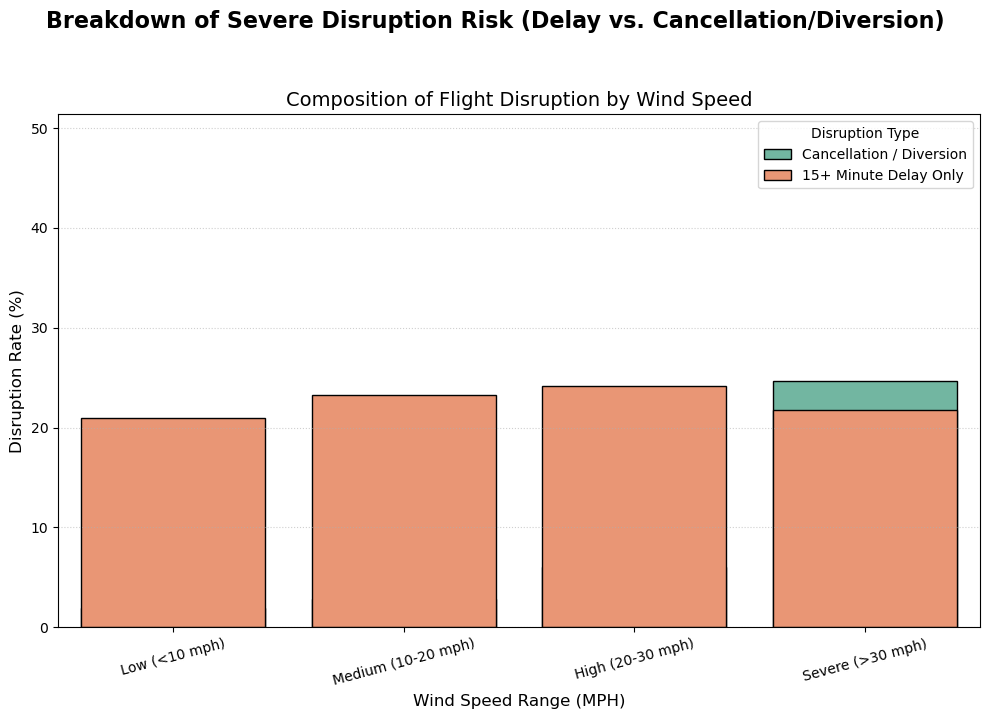

In [23]:
weather_cols = ['wspd'] 
n_cols = len(weather_cols)

# Set up the plot figure for a single bar chart
fig, axes = plt.subplots(
    nrows=1, 
    ncols=1, 
    figsize=(10, 7) # Increased size for clarity
)
axes = [axes] 

for i, col in enumerate(weather_cols):
    
    # 1. Create Bins (Categories) for Wind Speed
    if col == 'wspd':
        bins = [-np.inf, 10, 20, 30, np.inf]
        labels = ['Low (<10 mph)', 'Medium (10-20 mph)', 'High (20-30 mph)', 'Severe (>30 mph)']
        x_label = 'Wind Speed Range (MPH)'
        df[f'{col}_Category'] = pd.cut(df[col], bins=bins, labels=labels, right=True)
    
    # 2. Calculate the rate for each mutually exclusive category
    category_col = f'{col}_Category'
    delay_summary = df.groupby(category_col).agg(
        Cancelled_Diverted_Rate=('IsCancelledOrDiverted', 'mean'),
        Delayed_Only_Rate=('IsDelayedOnly', 'mean'),
        Total_Disruption_Rate=('IsSevereDisruption', 'mean') # Calculate total for annotations
    ).reset_index()

    # 3. Reshape the data for a stacked bar plot (melt)
    summary_melted = delay_summary.melt(
        id_vars=[category_col, 'Total_Disruption_Rate'], 
        value_vars=['Cancelled_Diverted_Rate', 'Delayed_Only_Rate'],
        var_name='Disruption_Type',
        value_name='Rate'
    )
    summary_melted['Rate_Pct'] = summary_melted['Rate'] * 100

    # Rename types for legend clarity
    summary_melted['Disruption_Type'] = summary_melted['Disruption_Type'].replace({
        'Cancelled_Diverted_Rate': 'Cancellation / Diversion',
        'Delayed_Only_Rate': '15+ Minute Delay Only'
    })
    
    # 4. Plot the stacked result
    sns.barplot(
        x=category_col, 
        y='Rate_Pct', 
        hue='Disruption_Type', # Use hue to create the segments
        data=summary_melted, 
        ax=axes[i], 
        palette='Set2', # A clearer palette for two groups
        edgecolor='black',
        dodge=False # CRITICAL: Set to False to make the bars stack
    )
    
    axes[i].set_title(f'Composition of Flight Disruption by Wind Speed', fontsize=14)
    axes[i].set_xlabel(x_label, fontsize=12)
    axes[i].set_ylabel('Disruption Rate (%)', fontsize=12)
    axes[i].set_ylim(0, delay_summary['Total_Disruption_Rate'].max() * 100 + 5)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].legend(title='Disruption Type')
    axes[i].grid(axis='y', linestyle=':', alpha=0.6)

fig.suptitle('Breakdown of Severe Disruption Risk (Delay vs. Cancellation/Diversion)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



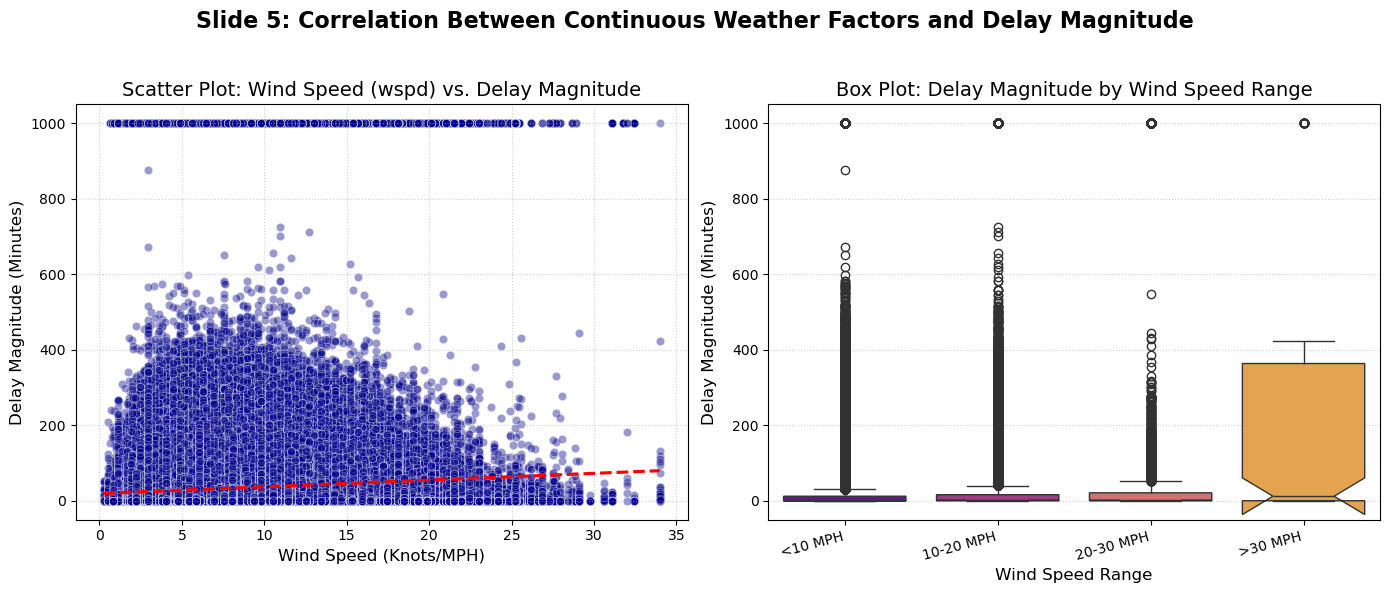

In [12]:
delay_magnitude_col = 'TotalDisruptionMinutes'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Option A: Scatter Plot (Delay Magnitude vs. Wind Speed) ---
sns.scatterplot(
    x='wspd', 
    y=delay_magnitude_col, 
    data=df_delayed, 
    alpha=0.4, 
    ax=ax1, 
    color='darkblue'
)
# Add a linear regression line for context
sns.regplot(
    x='wspd', 
    y=delay_magnitude_col, 
    data=df_delayed, 
    scatter=False, 
    color='red', 
    line_kws={'linestyle': '--', 'label': 'Linear Trend'}, 
    ax=ax1
)

ax1.set_title('Scatter Plot: Wind Speed (wspd) vs. Delay Magnitude', fontsize=14)
ax1.set_xlabel('Wind Speed (Knots/MPH)', fontsize=12)
ax1.set_ylabel('Delay Magnitude (Minutes)', fontsize=12)
ax1.grid(axis='both', linestyle=':', alpha=0.6)

# --- Option B: Box Plot (Delay Magnitude by Wind Speed Bin) ---
wind_bins = [-np.inf, 10, 20, 30, np.inf]
wind_labels = ['<10 MPH', '10-20 MPH', '20-30 MPH', '>30 MPH']

# Use the same logic as in Slide 4 to create ordered bins
df_delayed['Wind_Bin_Label'] = pd.cut(
    df_delayed['wspd'], 
    bins=wind_bins, 
    labels=wind_labels, 
    right=True, 
    duplicates='drop'
)

sns.boxplot(
    x='Wind_Bin_Label', # Use the fixed bins
    y=delay_magnitude_col, 
    data=df_delayed, 
    ax=ax2, 
    palette='plasma', 
    notch=True
)

ax2.set_title('Box Plot: Delay Magnitude by Wind Speed Range', fontsize=14)
ax2.set_xlabel('Wind Speed Range', fontsize=12)
ax2.set_ylabel('Delay Magnitude (Minutes)', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha='right')
ax2.grid(axis='y', linestyle=':', alpha=0.6)

fig.suptitle('Correlation Between Continuous Weather Factors and Delay Magnitude', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for suptitle
plt.show()

### Heatmap After Removing Highly Correlated and Unwanted Variables

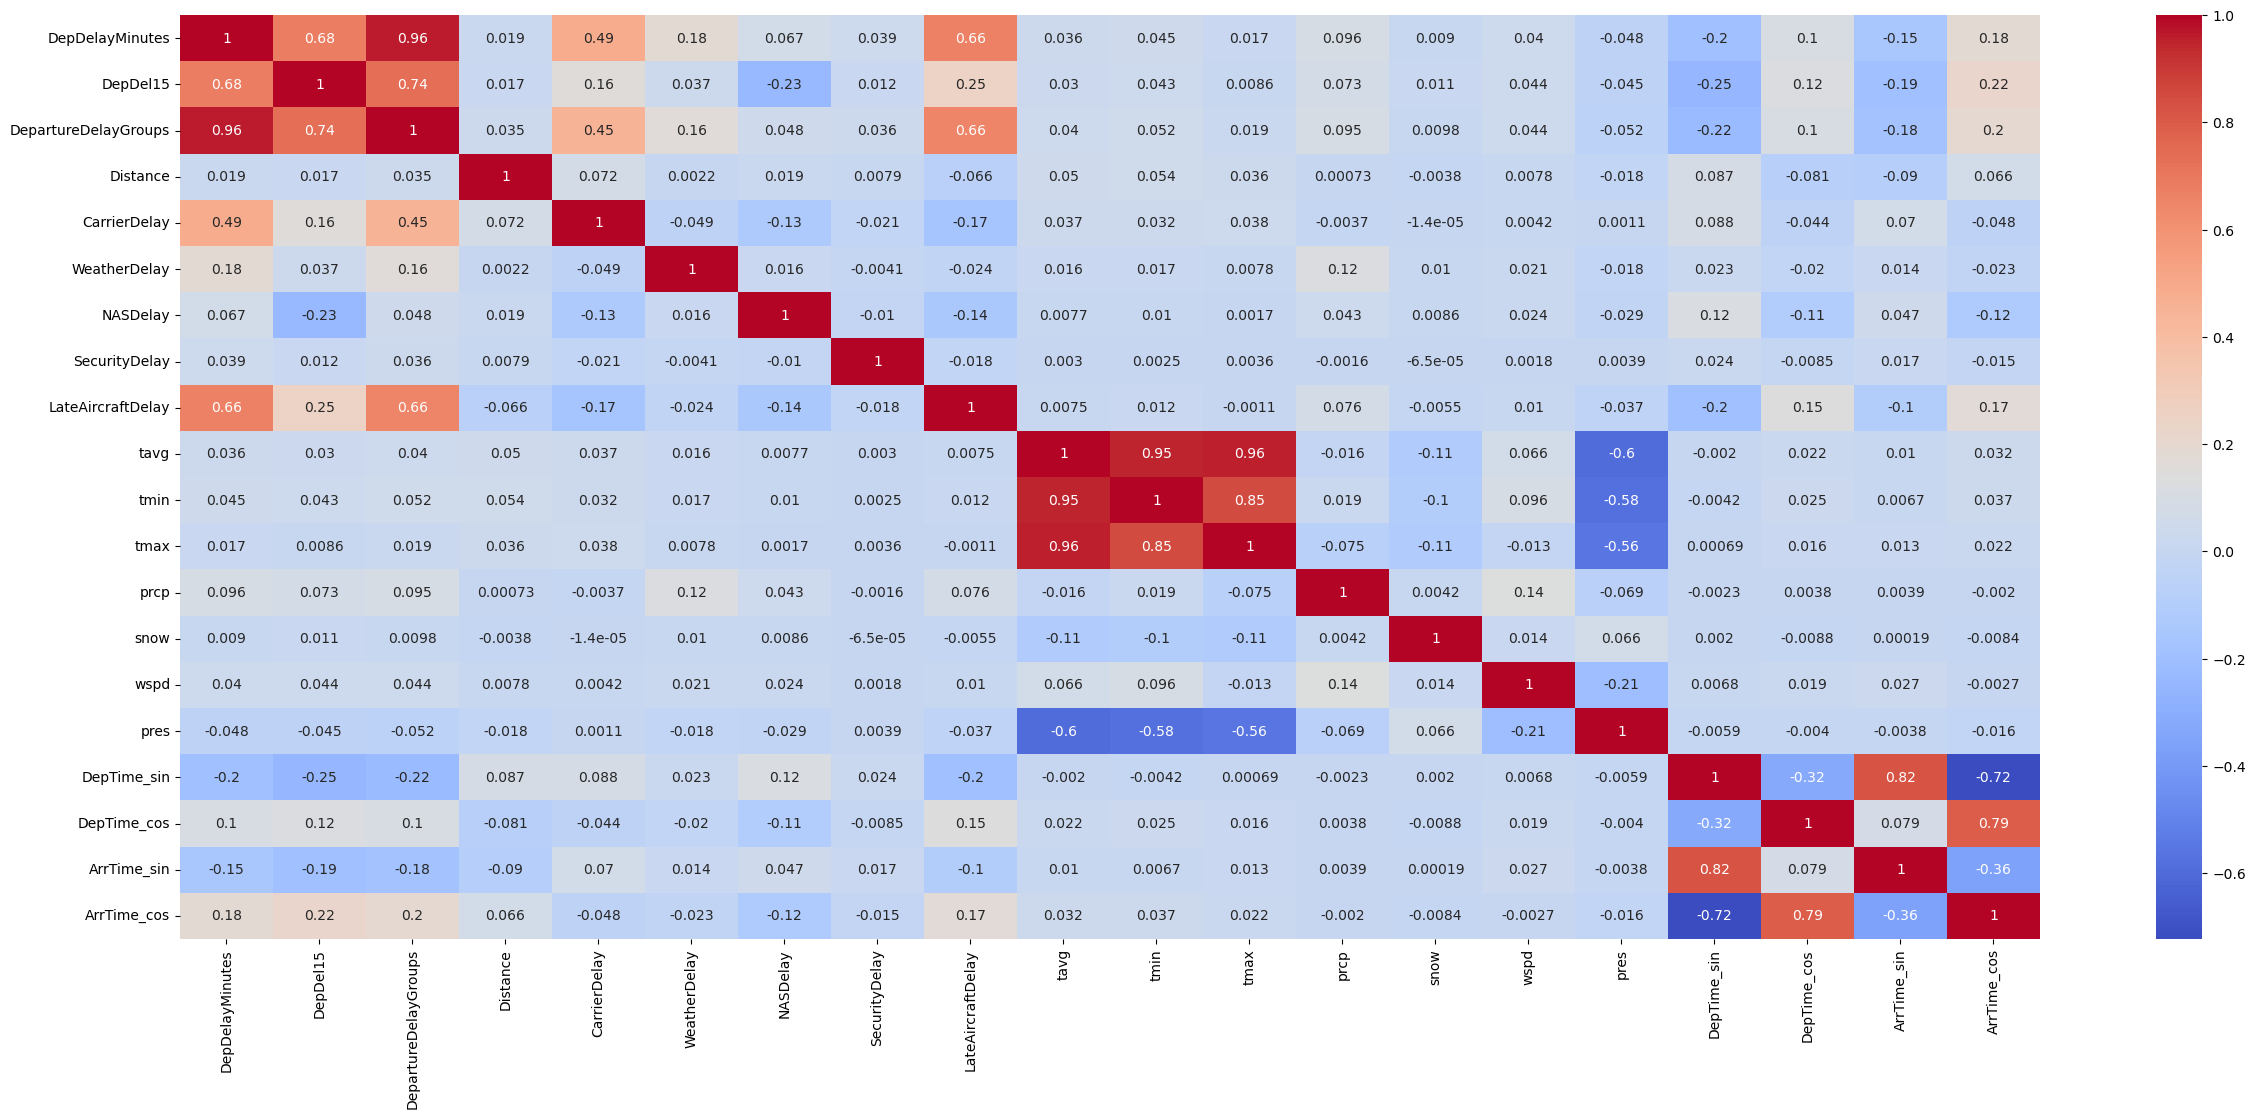

In [9]:
numeric_df = df.select_dtypes(include = ['number']).drop(columns = ['DepHour', 'DepMinute', 'DepTotalMinutes', 'ArrHour',
                    'ArrMinute', 'ArrTotalMinutes', 'Tail_Number', 'ArrDel15', 'DepDelay', 'WheelsOn', 'WheelsOff', 'TaxiIn', 'TaxiOut', 'ArrTime', 'ArrDelay', 
                    'ArrDelayMinutes', 'ArrivalDelayGroups', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DistanceGroup', 'DepTime', 
                    'Year', 'Quarter', 'DayofMonth', 'DivAirportLandings', 'DestAirportSeqID', 'Flights', 'OriginAirportID', 
                    'OriginStateFips', 'DestWac', 'OriginWac', 'CRSDepTime', 'CRSArrTime', 'Cancelled', 'DestStateFips', 
                    'DayOfWeek', 'Month', 'DOT_ID_Reporting_Airline', 'Flight_Number_Reporting_Airline', 'OriginCityMarketID', 
                    'Diverted', 'OriginAirportSeqID', 'DestAirportID', 'DestCityMarketID'], errors = 'ignore')
plt.figure(figsize = (30, 12))
sns.heatmap(numeric_df.corr(), annot = True, cmap = "coolwarm")
plt.show()

In [ ]:
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

In [ ]:
print("Dimension: ", df.shape)

# tavg missing rows
num_missing = df['tavg'].isna().sum()
print("\ntavg missing rows:", num_missing)

# wspd missing rows
num_missing = df['tmin'].isna().sum()
print("wspd missing rows:", num_missing)

# tmax missing rows
num_missing = df['tmax'].isna().sum()
print("tmax missing rows:", num_missing)

# tmin missing rows
num_missing = df['tmin'].isna().sum()
print("tmin missing rows:", num_missing)

# pres missing rows
num_missing = df['pres'].isna().sum()
print("pres missing rows:", num_missing)

# tmin missing rows
num_missing = df['prcp'].isna().sum()
print("prcp missing rows:", num_missing)

# snow missing rows
num_missing = df['snow'].isna().sum()
print("snow missing rows:", num_missing)

# delay missing rows
num_missing = df['DepDelayMinutes'].isna().sum()
print("delay missing rows:", num_missing)

### Resolving Missing Values for Model

In [ ]:
# df['tavg'] = df['tavg'].fillna(((df['tmin'] + df['tmax']) / 2).round().astype('Int64'))

# # Snow Step 1
# df['snow'] = df['snow'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['snow'].transform('mean')
# )

# # Snow Step 2
# df['snow'] = df['snow'].fillna(
#     df.groupby('Origin')['snow'].transform('mean')
# )


# df['tmin'] = df['tmin'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['tmin'].transform('mean')
# )

# df['tmax'] = df['tmax'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['tmax'].transform('mean')
# )

# df['wspd'] = df['wspd'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['wspd'].transform('mean')
# )

# df['pres'] = df['pres'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['pres'].transform('mean')
# )

# df['prcp'] = df['prcp'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['prcp'].transform('mean')
# )

# df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['DepDelayMinutes'].transform('mean')
# )

df = df.dropna(subset = ['DepDelayMinutes', 'snow', 'wspd', 'tmax', 'tmin', 'pres', 'prcp'])

## Feature Engineering

### Holidays

In [ ]:
expanded_holidays = set()

for d in range(25, 32):
    expanded_holidays.add((5, d))   # Memorial Day
for d in range(2, 7):
    expanded_holidays.add((7, d))   # Independence Day
for d in range(1, 8):
    expanded_holidays.add((9, d))   # Labor Day
for d in range(22, 29):
    expanded_holidays.add((11, d))  # Thanksgiving
for d in range(19, 32):
    expanded_holidays.add((12, d))  # Christmas
expanded_holidays.add((1, 1))       # New Year
for d in range(28, 32):
    expanded_holidays.add((3, d))    # Easter
for d in range(1, 3):
    expanded_holidays.add((4, d))    # Easter

# --- Vectorized encoding ---
# Create a tuple column and check membership in set
df["IsHoliday"] = list(zip(df["Month"], df["DayofMonth"]))
df["IsHoliday"] = df["IsHoliday"].isin(expanded_holidays).astype(int)

print(df[df["IsHoliday"] == 1].head())

### Saving New CSV

In [ ]:
df.to_csv("Data/FINAL_DATASET_CLEANED.csv", index = False)

### Reading Cleaned File

In [ ]:
df = pd.read_csv("Data/FINAL_DATASET_CLEANED.csv")

## Delays Over Time

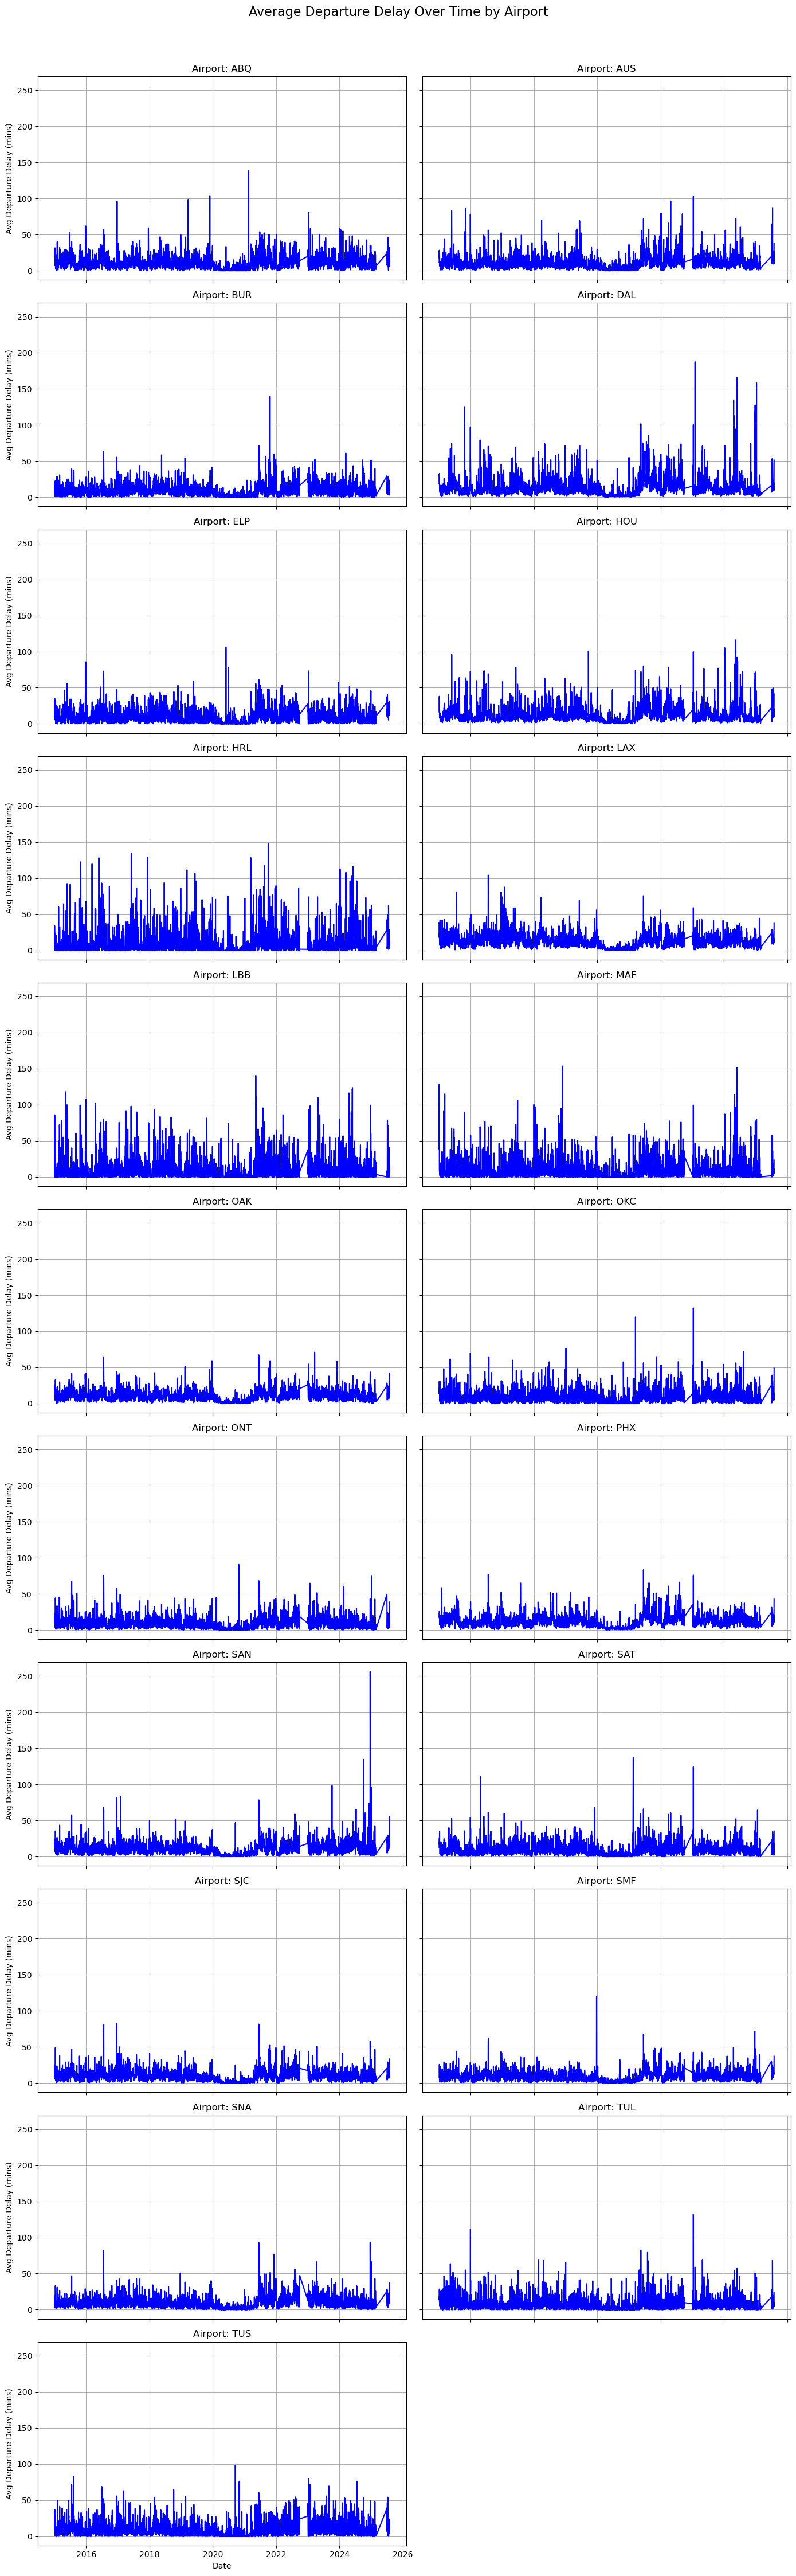

In [13]:
# Ensure date column is datetime
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

# ------------------------
# 2️⃣ Aggregate: average delay per day per airport
# ------------------------
avg_delay = (
    df.groupby(['FlightDate', 'Origin'])['DepDelayMinutes']
      .mean()
      .reset_index()
)

# ------------------------
# 3️⃣ Get unique airports
# ------------------------
airports = avg_delay['Origin'].unique()
num_airports = len(airports)

# ------------------------
# 4️⃣ Create subplots (one per airport)
# ------------------------
# Calculate number of rows and columns for subplots
cols = 2  # Adjust if you want more columns
rows = (num_airports + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily index

# Plot each airport
for i, airport in enumerate(airports):
    airport_data = avg_delay[avg_delay['Origin'] == airport]
    sns.lineplot(
        data=airport_data,
        x='FlightDate',
        y='DepDelayMinutes',
        ax=axes[i],
        color='blue'
    )
    axes[i].set_title(f"Airport: {airport}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Avg Departure Delay (mins)")
    axes[i].grid(True)

# Remove unused subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Average Departure Delay Over Time by Airport", y=1.02, fontsize=16)
plt.show()


### Log Transform

In [ ]:
df['DepDelayMinutes_log'] = np.log1p(df['DepDelayMinutes'])

## Step 2: Modeling

In [ ]:
# -------------------------
# 1️⃣ Define features & target
# -------------------------
features = ['Distance', 'wspd', 'tavg', 'prcp', 'pres', 'snow', 
            'tmin', 'tmax', 'DepTime_sin', 'DepTime_cos', 'ArrTime_sin', 'ArrTime_cos', 'IsHoliday']

one_hot_cols = [col for col in df.columns if col.startswith('Origin_') 
                or col.startswith('Month_') 
                or col.startswith('DayOfWeek_') 
                or col.startswith('Dest_')]

# target = 'DepDelayMinutes'
target = 'DepDelayMinutes_log'

X = df[features + one_hot_cols]
y = df[target]

X_sample = X.sample(500_000, random_state=42)
y_sample = y.loc[X_sample.index]
dates_sample = df.loc[X_sample.index, 'FlightDate']

# Define train and test ranges explicitly
train_start, train_end = '2015-01-01', '2019-12-31'
test_start, test_end   = '2023-01-01', '2024-07-31'

# Filter for train and test
train_mask = (dates_sample >= train_start) & (dates_sample <= train_end)
test_mask  = (dates_sample >= test_start)  & (dates_sample <= test_end)

X_train = X_sample[train_mask]
y_train = y_sample[train_mask]

X_test  = X_sample[test_mask]
y_test  = y_sample[test_mask]

# X_train, X_test, y_train, y_test = train_test_split(
#     X_sample, y_sample, test_size=0.2, random_state=42
# )

# -------------------------
# 2️⃣ Train Random Forest
# -------------------------
rf = RandomForestRegressor(
    n_estimators=120,
    random_state=42,
    n_jobs=-1,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1
)
rf.fit(X_train, y_train)

# -------------------------
# 3️⃣ Predict on train & test
# -------------------------
y_train_pred = rf.predict(X_train)
y_test_pred  = rf.predict(X_test)

# -------------------------
# 4️⃣ Compute errors
# -------------------------
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)

train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse  = root_mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test, y_test_pred)

print(f"Train MAE:  {train_mae:.2f}, Test MAE:  {test_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R²:   {train_r2:.3f}, Test R²:   {test_r2:.3f}")

# -------------------------
# 5️⃣ Plot train vs test error
# -------------------------
metrics = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'MAE': [train_mae, test_mae],
    'RMSE': [train_rmse, test_rmse],
    'R2': [train_r2, test_r2]
})

plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='MAE', data=metrics, palette='Blues')
plt.title("Train vs Test MAE")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='RMSE', data=metrics, palette='Oranges')
plt.title("Train vs Test RMSE")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='R2', data=metrics, palette='Greens')
plt.title("Train vs Test R²")
plt.show()

# -------------------------
# 6️⃣ Feature importance plot
# -------------------------
importances = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')
plt.title("Top 15 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()

## LightGBM

In [ ]:
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
# -------------------------
# 1️⃣ Define features & log-transformed target
# -------------------------
features = ['Distance', 'wspd', 'tavg', 'prcp', 'pres', 'snow', 
            'tmin', 'tmax', 'DepTime_sin', 'DepTime_cos', 'ArrTime_sin', 'ArrTime_cos', 'IsHoliday']

one_hot_cols = [col for col in df.columns if col.startswith('Origin_') 
                or col.startswith('Month_') 
                or col.startswith('DayOfWeek_') 
                or col.startswith('Dest_')]

target = 'DepDelayMinutes_log'

X = df[features + one_hot_cols]
y = df[target]

# Optional sampling
X_sample = X.sample(1_000, random_state=42)
y_sample = y.loc[X_sample.index]
dates_sample = df.loc[X_sample.index, 'FlightDate']

# -------------------------
# 2️⃣ Time-based train/test split
# -------------------------
train_start, train_end = '2015-01-01', '2019-12-31'
test_start, test_end   = '2023-01-01', '2024-07-31'

train_mask = (dates_sample >= train_start) & (dates_sample <= train_end)
test_mask  = (dates_sample >= test_start)  & (dates_sample <= test_end)

X_train = X_sample[train_mask]
y_train = y_sample[train_mask]

X_test  = X_sample[test_mask]
y_test  = y_sample[test_mask]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# -------------------------
# 3️⃣ Hyperparameter ranges
# -------------------------
learning_rates = [0.01, 0.005, 0.1]
num_leaves_list = [31, 50, 100]
max_depths = [10, 15, 20]
n_estimators_list = [500, 1000]

best_rmse = float('inf')
best_params = None
best_model = None

# -------------------------
# 4️⃣ Manual grid search
# -------------------------
for lr in learning_rates:
    for leaves in num_leaves_list:
        for depth in max_depths:
            for n_est in n_estimators_list:
                params = {
                    'objective': 'regression',
                    'metric': 'rmse',
                    'learning_rate': lr,
                    'num_leaves': leaves,
                    'max_depth': depth,
                    'verbosity': -1,
                    'n_jobs': -1
                }
                
                lgb_train = lgb.Dataset(X_train, label=y_train)
                lgb_test  = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
                
                model = lgb.train(
                    params,
                    lgb_train,
                    num_boost_round=n_est,
                    valid_sets=[lgb_train, lgb_test],
                    valid_names=['train','test'],
                    callbacks=[
                        lgb.callback.early_stopping(stopping_rounds=50),
                        lgb.callback.log_evaluation(period=50)
                    ]
                )
                
                # Predict & back-transform
                y_test_pred_log = model.predict(X_test)
                y_test_pred = np.expm1(y_test_pred_log)
                y_test_actual = np.expm1(y_test)
                
                rmse = root_mean_squared_error(y_test_actual, y_test_pred)
                
                print(f"lr={lr}, leaves={leaves}, depth={depth}, n_estimators={n_est} --> RMSE={rmse:.2f}")
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {'learning_rate': lr, 'num_leaves': leaves, 'max_depth': depth, 'n_estimators': n_est}
                    best_model = model

print("\nBest params:", best_params)
print("Best test RMSE:", best_rmse)

# -------------------------
# 5️⃣ Predictions with best model
# -------------------------
y_train_pred_log = best_model.predict(X_train)
y_test_pred_log  = best_model.predict(X_test)

y_train_pred = np.expm1(y_train_pred_log)
y_test_pred  = np.expm1(y_test_pred_log)

y_train_actual = np.expm1(y_train)
y_test_actual  = np.expm1(y_test)

# -------------------------
# 6️⃣ Compute errors
# -------------------------
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae  = mean_absolute_error(y_test_actual, y_test_pred)

train_rmse = root_mean_squared_error(y_train_actual, y_train_pred)
test_rmse  = root_mean_squared_error(y_test_actual, y_test_pred)

train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2  = r2_score(y_test_actual, y_test_pred)

print(f"Train MAE:  {train_mae:.2f}, Test MAE:  {test_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R²:   {train_r2:.3f}, Test R²:   {test_r2:.3f}")

# -------------------------
# 7️⃣ Plot train vs test error
# -------------------------
metrics = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'MAE': [train_mae, test_mae],
    'RMSE': [train_rmse, test_rmse],
    'R2': [train_r2, test_r2]
})

plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='MAE', data=metrics, palette='Blues')
plt.title("Train vs Test MAE")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='RMSE', data=metrics, palette='Oranges')
plt.title("Train vs Test RMSE")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='R2', data=metrics, palette='Greens')
plt.title("Train vs Test R²")
plt.show()

# -------------------------
# 8️⃣ Feature importance plot
# -------------------------
importances = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': best_model.feature_importance()
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')
plt.title("Top 15 Most Important Features (LightGBM)")
plt.tight_layout()
plt.show()


In [ ]:
sns.histplot(df['DepDelayMinutes_log'], bins=5)
plt.xlim(0, 10)
plt.show()

### Box-Cox

In [ ]:
from scipy.stats import boxcox

df['DepDelayMinutes_boxcox'], lam = boxcox(df['DepDelayMinutes'] + 1)  # +1 to handle zeros
sns.histplot(df['DepDelayMinutes_boxcox'], bins=5)
plt.xlim(0, 10)
plt.show()

# Original LightGBM stuff

1. exclude covid window (contiguous before and after covid)
2. interpolate values through covid? (use new dataset/df)
3. train/test split graphs and performance
4. extend feature engineering
5. extend/vary holiday window

- hourly meteostat data
- noaa one stop data
- more weather variables (doc)

# Imports

In [ ]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor as lgbm, early_stopping
import optuna

# Step 1: Data Collection and Preprocessing

## Data Collection

### Import Data

In [ ]:
df = pd.read_csv("FINAL_DATASET.csv")

/var/folders/hb/9n_ph5yj0491qld3nd7lpr900000gn/T/ipykernel_54950/1800989504.py:1: DtypeWarning: Columns (76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("FINAL_DATASET.csv")


### Display Data

In [ ]:
print(df.head())
print("Data Range:")
print(df['FlightDate'].iloc[[0, -1]])

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2015        3      8           3          1  2015-08-03                WN   
1  2015        3      8           3          1  2015-08-03                WN   
2  2015        3      8           3          1  2015-08-03                WN   
3  2015        3      8           3          1  2015-08-03                WN   
4  2015        3      8           3          1  2015-08-03                WN   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  \
0                     19393                          WN      N7743B   
1                     19393                          WN      N525SW   
2                     19393                          WN      N528SW   
3                     19393                          WN      N523SW   
4                     19393                          WN      N515SW   

   Flight_Number_Reporting_Airline  OriginAirportID  OriginAirportSeqID  \
0                

In [ ]:
df_grouped = df.groupby(['Origin', 'Dest', 'Month', 'DayOfWeek']).agg({
    'DepDelayMinutes': 'mean',
    'wspd': 'mean', 'tavg': 'mean', 'tmin': 'mean', 'tmax': 'mean', 'prcp': 'mean', 
    'snow': 'mean', 'wdir': 'mean', 'wspd': 'mean', 'wpgt': 'mean', 'pres': 'mean', 
}).reset_index()


## Data Preprocessing

### Converting to Imperial

In [ ]:
import pandas as pd
df = pd.read_csv("FINAL_DATASET.csv")

# Temperature: Convert °C to °F
for col in ["tavg", "tmin", "tmax"]:
    if col in df.columns:
        df[col] = (df[col] * 9/5 + 32).round().astype("Int64")

# Precipitation & Snow: Convert mm to inches
for col in ["prcp", "snow"]:
    if col in df.columns:
        df[col] = df[col] / 25.4

# Wind Speed: Convert km/h to mph
if "wspd" in df.columns:
    df["wspd"] = df["wspd"] / 1.60934

# Pressure: Convert hPa to inHg
if "pres" in df.columns:
    df["pres"] = df["pres"] * 0.02953

print(df.head(1))

/var/folders/hb/9n_ph5yj0491qld3nd7lpr900000gn/T/ipykernel_54950/2290103901.py:2: DtypeWarning: Columns (76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("FINAL_DATASET.csv")


   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2015        3      8           3          1  2015-08-03                WN   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  \
0                     19393                          WN      N7743B   

   Flight_Number_Reporting_Airline  OriginAirportID  OriginAirportSeqID  \
0                           2066.0            12896             1289605   

   OriginCityMarketID Origin OriginCityName OriginState  OriginStateFips  \
0               32896    LBB    Lubbock, TX          TX               48   

  OriginStateName  OriginWac  DestAirportID  DestAirportSeqID  \
0           Texas         74          10423           1042302   

   DestCityMarketID Dest DestCityName DestState  DestStateFips DestStateName  \
0             30423  AUS   Austin, TX        TX             48         Texas   

   DestWac  CRSDepTime  DepTime  DepDelay  DepDelayMinutes  DepDel15  \
0       74         630    63

### Treating Missing Values

In [ ]:
# Percentage NA by column
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False).head(75))

# Removing >3% missing cols and IATA Code column due to redundancy
cols_to_drop = percent_na[percent_na > 3].index
df = df.drop(columns = cols_to_drop)

print(f"\nDropped {len(cols_to_drop)} columns")
print("Remaining columns: ", len(df.columns))

# Printing percentage again
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

# Drop NaN rows
df.dropna(inplace=True)

Div3Airport             100.000000
Div3AirportSeqID        100.000000
Div3TotalGTime          100.000000
Div3LongestGTime        100.000000
Div3WheelsOff           100.000000
Div3TailNum             100.000000
Div4Airport             100.000000
Div4AirportID           100.000000
Div4AirportSeqID        100.000000
Div4WheelsOn            100.000000
Div4TotalGTime          100.000000
Div4LongestGTime        100.000000
Div4WheelsOff           100.000000
Div4TailNum             100.000000
Div5Airport             100.000000
Div5AirportID           100.000000
Div5AirportSeqID        100.000000
Div5WheelsOn            100.000000
Div5TotalGTime          100.000000
Div5LongestGTime        100.000000
Div5WheelsOff           100.000000
Div5TailNum             100.000000
Unnamed: 109            100.000000
wdir                    100.000000
Div3AirportID           100.000000
Div3WheelsOn            100.000000
tsun                     99.999711
Div2TailNum              99.999578
Div2WheelsOff       

### Heatmap After Removing Highly Correlated and Unwanted Variables

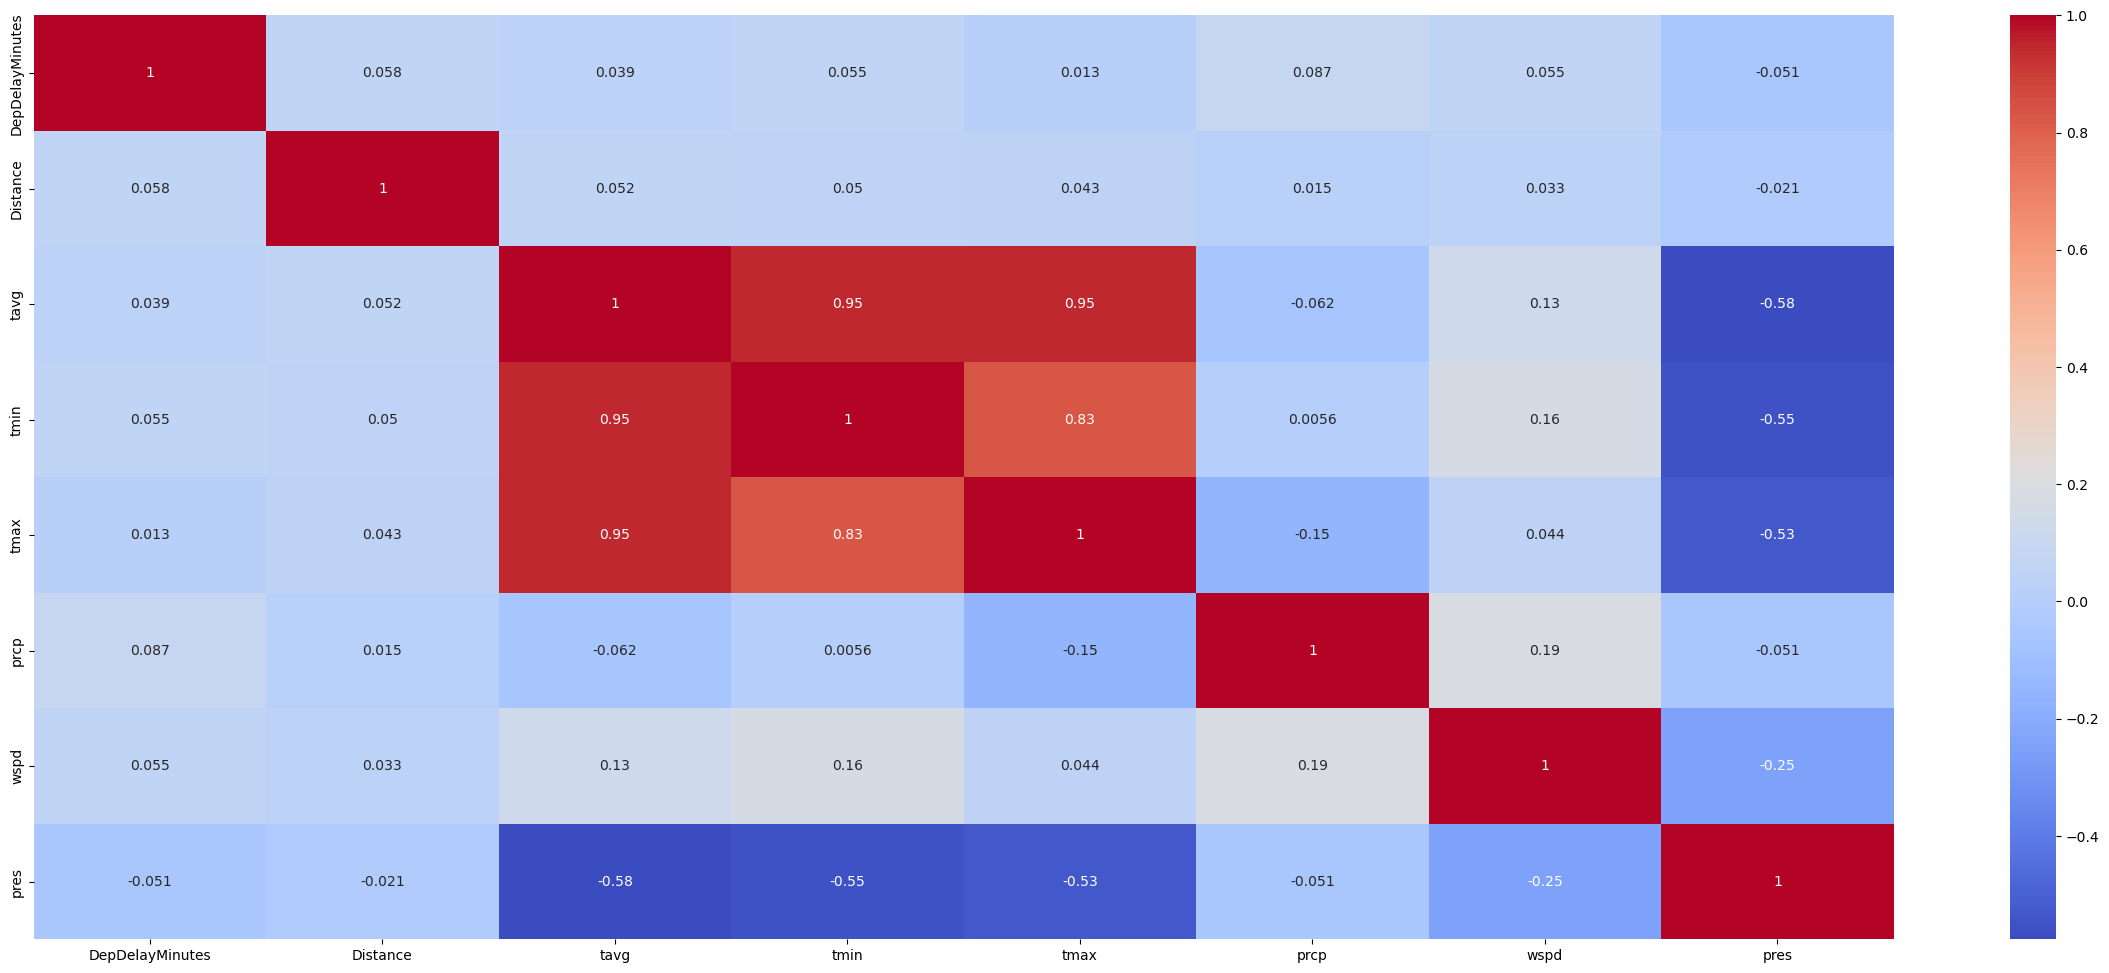

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# df = df.drop(columns = ['Tail_Number', 'ArrDel15', 'DepDelay', 'WheelsOn', 'WheelsOff', 'TaxiIn', 'TaxiOut', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrivalDelayGroups', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DistanceGroup'])
# df = df.drop(columns = ['DepDel15', 'DepartureDelayGroups'])
numeric_df = df.select_dtypes(include = ['number']).drop(columns = ['DepTime', 'Year', 'Quarter', 'DayofMonth', 'DivAirportLandings', 'DestAirportSeqID', 'Flights', 'OriginAirportID', 'OriginStateFips', 'DestWac', 'OriginWac', 'CRSDepTime', 'CRSArrTime', 'Cancelled', 'DestStateFips', 'DayOfWeek', 'Month', 'DOT_ID_Reporting_Airline', 'Flight_Number_Reporting_Airline', 'OriginCityMarketID', 'Diverted', 'OriginAirportSeqID', 'DestAirportID', 'DestCityMarketID'], errors = 'ignore')
plt.figure(figsize = (30, 12))
sns.heatmap(numeric_df.corr(method='spearman'), annot = True, cmap = "coolwarm")
plt.show()

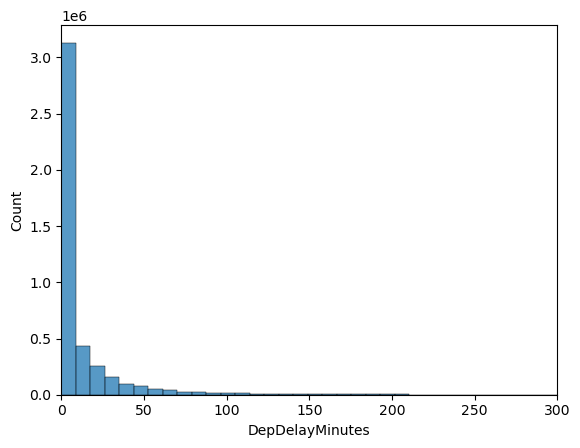

In [ ]:
sns.histplot(df['DepDelayMinutes'], bins=100)
plt.xlim(0, 300)
plt.show()

The extreme right skew, combined with the low correlation coefficients, indicates we need to perform some feature engineering to help the model find relations between weather data and delay lengths.

In [ ]:
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

DepTime                            1.899147
DepDelayMinutes                    1.899147
DepDel15                           1.899147
DepartureDelayGroups               1.899147
prcp                               0.458100
pres                               0.073344
tmax                               0.008974
tmin                               0.008974
wspd                               0.000844
tavg                               0.000244
DepTimeBlk                         0.000000
DestStateName                      0.000000
DestWac                            0.000000
CRSDepTime                         0.000000
Cancelled                          0.000000
CRSArrTime                         0.000000
ArrTimeBlk                         0.000000
Quarter                            0.000000
Diverted                           0.000000
Flights                            0.000000
Distance                           0.000000
DivAirportLandings                 0.000000
DestStateFips                   

### Delays Over Time

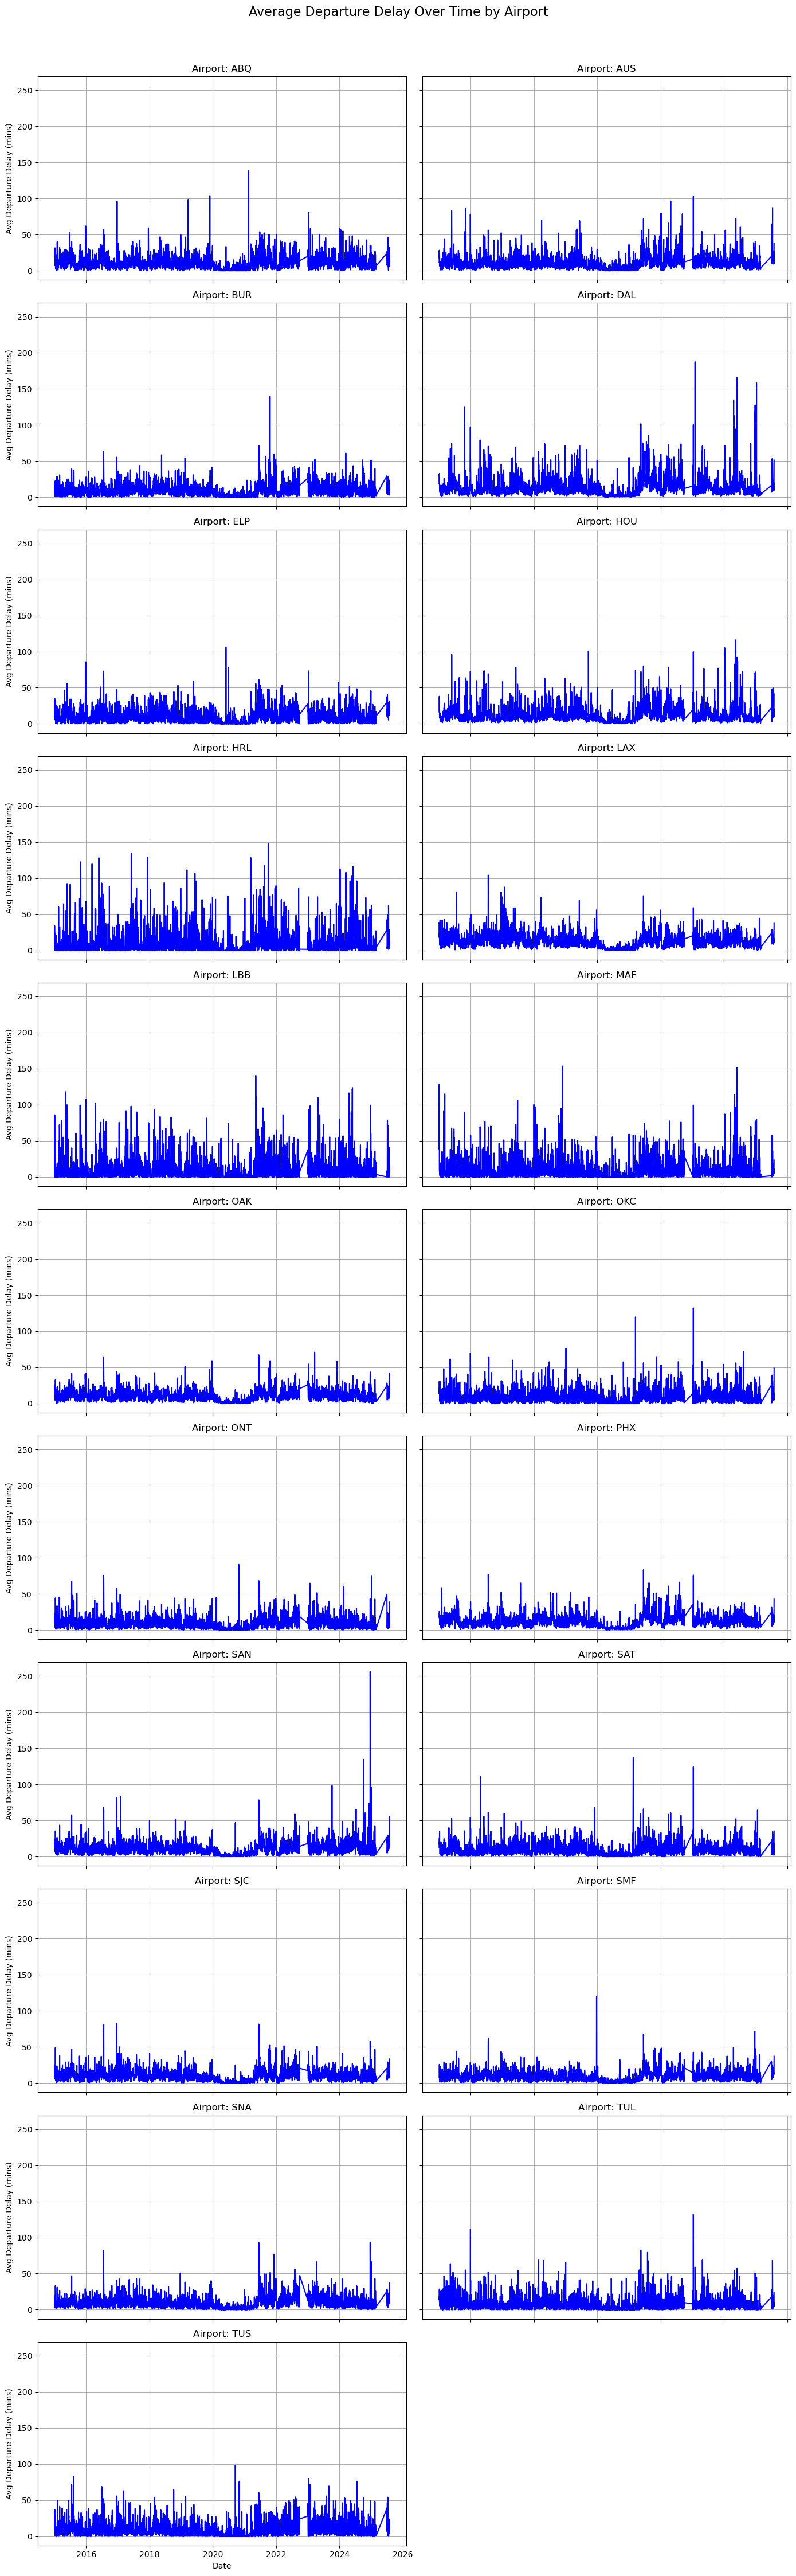

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date column is datetime
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

# ------------------------
# 2️⃣ Aggregate: average delay per day per airport
# ------------------------
avg_delay = (
    df.groupby(['FlightDate', 'Origin'])['DepDelayMinutes']
      .mean()
      .reset_index()
)

# ------------------------
# 3️⃣ Get unique airports
# ------------------------
airports = avg_delay['Origin'].unique()
num_airports = len(airports)

# ------------------------
# 4️⃣ Create subplots (one per airport)
# ------------------------
# Calculate number of rows and columns for subplots
cols = 2  # Adjust if you want more columns
rows = (num_airports + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily index

# Plot each airport
for i, airport in enumerate(airports):
    airport_data = avg_delay[avg_delay['Origin'] == airport]
    sns.lineplot(
        data=airport_data,
        x='FlightDate',
        y='DepDelayMinutes',
        ax=axes[i],
        color='blue'
    )
    axes[i].set_title(f"Airport: {airport}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Avg Departure Delay (mins)")
    axes[i].grid(True)

# Remove unused subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Average Departure Delay Over Time by Airport", y=1.02, fontsize=16)
plt.show()


### Transform Target

Log Transformation

In [ ]:
df['DepDelayMinutes_log'] = np.log1p(df['DepDelayMinutes'])

Box-Cox Transformation

In [ ]:
df['DepDelay_shifted'] = df['DepDelayMinutes'] + 1e-3  # avoid zeros
pt_boxcox = PowerTransformer(method='box-cox', standardize=False)
df['DepDelayMinutes_boxcox'] = pt_boxcox.fit_transform(df['DepDelay_shifted'].values.reshape(-1,1))

Yeo-Johnson Transformation

In [ ]:
pt_yeojohnson = PowerTransformer(method='yeo-johnson', standardize=False)
df['DepDelayMinutes_yeojohnson'] = pt_yeojohnson.fit_transform(df['DepDelayMinutes'].values.reshape(-1,1))

## Feature Engineering

### Extra Features

In [ ]:
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

# DayOfYear: Day of the year (1-365/366)
df['DayOfYear'] = df['FlightDate'].dt.dayofyear

# IsWeekend: 1 if the flight date is Saturday or Sunday, else 0
df['IsWeekend'] = df['DayOfWeek'].isin([6,7]).astype(int)

# IsHoliday: 1 if the flight date is a US federal holiday, else 0
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df['FlightDate'].min(), end=df['FlightDate'].max())
df['IsHoliday'] = df['FlightDate'].isin(holidays)

# IsHolidayWindow: within 1 day before or after a holiday
holiday_window = pd.concat([
    pd.Series(holidays - pd.Timedelta(days=1)),
    pd.Series(holidays),
    pd.Series(holidays + pd.Timedelta(days=1))
])
df['IsHolidayWindow'] = df['FlightDate'].isin(holiday_window)

# NumDepartures: number of departures from the origin airport on that day
daily_departures = (
    df.groupby(['OriginAirportID', 'FlightDate'])
      .size()
      .rename('NumDepartures')
      .reset_index()
)

df = df.merge(daily_departures, on=['OriginAirportID', 'FlightDate'], how='left')

# Ensure Date column exists and is datetime
df['Date'] = pd.to_datetime(df['FlightDate'])

# Sort so rolling ops are time-consistent
df = df.sort_values(['OriginAirportID', 'Date'])

# RouteDelayMean_7d: Route-level rolling delay mean
df['Route'] = df['OriginAirportID'].astype(str) + '_' + df['DestAirportID'].astype(str)
df['RouteDelayMean_7d'] = (
    df.groupby('Route')['DepDelayMinutes']
      .transform(lambda x: x.shift().rolling(7, min_periods=1).mean())
)

# OriginDelayMean_7d: Airport-level (origin) rolling delay mean
df['OriginDelayMean_7d'] = (
    df.groupby('OriginAirportID')['DepDelayMinutes']
      .transform(lambda x: x.shift().rolling(7, min_periods=1).mean())
)

# DestArrivals_7d: Destination congestion indicator
df['DestArrivals_7d'] = (
    df.groupby('DestAirportID')['Flight_Number_Reporting_Airline']
      .transform(lambda x: x.shift().rolling(7, min_periods=1).count())
)

# Replace any remaining NaN (from shift/rolling) with reasonable defaults
df.fillna({
    'RouteDelayMean_7d': 0,
    'OriginDelayMean_7d': 0,
    'DestArrivals_7d': 0
}, inplace=True)

# Departures_Today: Day-level departure volume (can help with congestion)
df['Departures_Today'] = df.groupby(['OriginAirportID', 'Date'])['Flight_Number_Reporting_Airline'].transform('count')

# Interaction features (useful for nonlinear models like LightGBM)
df['Dist_x_Wspd'] = df['Distance'] * df['wspd']
df['TempRange'] = df['tmax'] - df['tmin']
df['MonthxWeekday'] = df['Month'] * df['DayOfWeek']

# CongestionRatio: Ratio of today's departures to average departures for that airport
df['AvgDepartures_Past30d'] = (
    df.groupby('OriginAirportID')['NumDepartures']
      .transform(lambda x: x.shift().rolling(30, min_periods=1).mean())
)
df['CongestionRatio'] = df['NumDepartures'] / df['AvgDepartures_Past30d']

# OriginDelayTrend_3d: Captures worsening congestion trend
df['OriginDelayTrend_3d'] = df.groupby('OriginAirportID')['OriginDelayMean_7d'].transform(lambda x: x.diff(3))

# DayOfYear cyclical features avoid discontinuity from 12-31 to 01-01
df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear']/365)
df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear']/365)

# HighDelayFlag: binary indicator if delay > 60 mins
df['HighDelayFlag'] = (df['DepDelayMinutes'] > 60).astype(int)



# Step 2: Modeling

### Feature Selection & Splitting

In [ ]:
features = [

    # 'Year', Removing Year to focus on dynamic predictors 
    'Month', 'DayOfWeek', 'Flight_Number_Reporting_Airline',
    'OriginAirportID', 'OriginCityMarketID', 'OriginStateFips',
    'DestAirportID', 'DestCityMarketID', 'DestStateFips',
    'CRSDepTime', 'CRSArrTime', 'Distance', 'tavg', 'tmin', 'tmax',
    'prcp', 'wspd', 'pres', 'IsWeekend', 'IsHoliday', 'IsHolidayWindow',
    'NumDepartures', 'RouteDelayMean_7d', 'OriginDelayMean_7d', 
    'DestArrivals_7d', 'Departures_Today', 'Dist_x_Wspd', 'TempRange',
    'MonthxWeekday', 'AvgDepartures_Past30d', 'OriginDelayTrend_3d',
    'DayOfYear_sin', 'DayOfYear_cos', 'CongestionRatio',
    'HighDelayFlag'
]
# One-hot encoded categorical variables
one_hot_cols = [col for col in df.columns if col.startswith('Origin_') or 
                col.startswith('Month_') or 
                col.startswith('DayOfWeek_') or 
                col.startswith('Dest_')]

target = 'DepDelayMinutes_boxcox'

# Define X and y
X = df[features + one_hot_cols]
y = df[target]

# Keep FlightDate in a separate series for splitting
flight_dates = df['FlightDate']

# Subsample for speed
df_model = df[features + one_hot_cols + [target]].dropna().sample(500_000, random_state=42)
flight_dates_model = flight_dates.loc[df_model.index]

# Time-based split
train_end = '2023-12-31'
valid_end = '2024-12-31'

train_mask = flight_dates_model <= train_end
valid_mask = (flight_dates_model > train_end) & (flight_dates_model <= valid_end)
test_mask = flight_dates_model > valid_end

# Define X and y
X = df_model[features + one_hot_cols]  # do NOT include FlightDate
y = df_model[target]

# Split and convert numeric to float32
X_train = X[train_mask].astype(np.float32)
X_valid = X[valid_mask].astype(np.float32)
X_test  = X[test_mask].astype(np.float32)

y_train = y[train_mask]
y_valid = y[valid_mask]
y_test  = y[test_mask]

### LightGBM

#### Hyper Parameter Tuning

In [ ]:
def objective(trial):
    params = {
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 500),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = lgbm(**params)
    model.fit(
        X_train, y_train,  # y_train is transformed
        eval_set=[(X_valid, y_valid)],
        eval_metric='mae',
        callbacks=[early_stopping(stopping_rounds=100)]
    )
    
    # Back-transform predictions to minutes
    y_pred_log = model.predict(X_valid)
    y_pred = np.expm1(y_pred_log)
    y_valid_orig = np.expm1(y_valid)
    
    mae = mean_absolute_error(y_valid_orig, y_pred)
    return mae  # Optuna minimizes MAE in minutes

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # adjust trials as needed

print("Best hyperparameters:")
print(study.best_params)
print("Best MAE:", study.best_value)

[I 2025-11-09 14:43:01,485] A new study created in memory with name: no-name-9e14b6e5-4e5b-43fc-aa20-910a864c511a


[LightGBM] [Warning] lambda_l1 is set=0.2917580724858375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2917580724858375
[LightGBM] [Warning] feature_fraction is set=0.9859003930300703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9859003930300703
[LightGBM] [Warning] bagging_fraction is set=0.9350065104615204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9350065104615204
[LightGBM] [Warning] lambda_l2 is set=0.6276226543519203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6276226543519203
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=0.2917580724858375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2917580724858375
[LightGBM] [Warning] feature_fraction is set=0.9859003930300703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9859003930300703
[LightGBM] [Warning] ba

[I 2025-11-09 14:43:22,686] Trial 0 finished with value: 6.297741894021955 and parameters: {'learning_rate': 0.004538938116999676, 'num_leaves': 25, 'min_data_in_leaf': 60, 'feature_fraction': 0.9859003930300703, 'bagging_fraction': 0.9350065104615204, 'lambda_l1': 0.2917580724858375, 'lambda_l2': 0.6276226543519203}. Best is trial 0 with value: 6.297741894021955.


[LightGBM] [Warning] lambda_l1 is set=0.02157723421200075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02157723421200075
[LightGBM] [Warning] feature_fraction is set=0.7332814507979286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7332814507979286
[LightGBM] [Warning] bagging_fraction is set=0.8945892139195727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8945892139195727
[LightGBM] [Warning] lambda_l2 is set=0.1541413605402402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1541413605402402
[LightGBM] [Warning] min_data_in_leaf is set=399, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=399
[LightGBM] [Warning] lambda_l1 is set=0.02157723421200075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02157723421200075
[LightGBM] [Warning] feature_fraction is set=0.7332814507979286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7332814507979286
[LightGBM] [Warni

[I 2025-11-09 14:43:44,202] Trial 1 finished with value: 6.5242895921367285 and parameters: {'learning_rate': 0.006769808092909521, 'num_leaves': 31, 'min_data_in_leaf': 399, 'feature_fraction': 0.7332814507979286, 'bagging_fraction': 0.8945892139195727, 'lambda_l1': 0.02157723421200075, 'lambda_l2': 0.1541413605402402}. Best is trial 0 with value: 6.297741894021955.


[LightGBM] [Warning] lambda_l1 is set=0.5002781277347148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5002781277347148
[LightGBM] [Warning] feature_fraction is set=0.555916613332261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.555916613332261
[LightGBM] [Warning] bagging_fraction is set=0.7075046699894991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7075046699894991
[LightGBM] [Warning] lambda_l2 is set=0.23330019058913898, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23330019058913898
[LightGBM] [Warning] min_data_in_leaf is set=372, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=372
[LightGBM] [Warning] lambda_l1 is set=0.5002781277347148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5002781277347148
[LightGBM] [Warning] feature_fraction is set=0.555916613332261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.555916613332261
[LightGBM] [Warning] ba

[I 2025-11-09 14:44:42,165] Trial 2 finished with value: 6.3239136610701205 and parameters: {'learning_rate': 0.002698305276805181, 'num_leaves': 174, 'min_data_in_leaf': 372, 'feature_fraction': 0.555916613332261, 'bagging_fraction': 0.7075046699894991, 'lambda_l1': 0.5002781277347148, 'lambda_l2': 0.23330019058913898}. Best is trial 0 with value: 6.297741894021955.


[LightGBM] [Warning] lambda_l1 is set=0.28308514636317583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28308514636317583
[LightGBM] [Warning] feature_fraction is set=0.9056834040215134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9056834040215134
[LightGBM] [Warning] bagging_fraction is set=0.7335973497126929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7335973497126929
[LightGBM] [Warning] lambda_l2 is set=0.11670790510630824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11670790510630824
[LightGBM] [Warning] min_data_in_leaf is set=391, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=391
[LightGBM] [Warning] lambda_l1 is set=0.28308514636317583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28308514636317583
[LightGBM] [Warning] feature_fraction is set=0.9056834040215134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9056834040215134
[LightGBM] [War

[I 2025-11-09 14:44:55,528] Trial 3 finished with value: 6.204261911355792 and parameters: {'learning_rate': 0.02422382553614365, 'num_leaves': 192, 'min_data_in_leaf': 391, 'feature_fraction': 0.9056834040215134, 'bagging_fraction': 0.7335973497126929, 'lambda_l1': 0.28308514636317583, 'lambda_l2': 0.11670790510630824}. Best is trial 3 with value: 6.204261911355792.


[LightGBM] [Warning] lambda_l1 is set=0.38747585245873095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38747585245873095
[LightGBM] [Warning] feature_fraction is set=0.5017253573347858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5017253573347858
[LightGBM] [Warning] bagging_fraction is set=0.7856584306970947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7856584306970947
[LightGBM] [Warning] lambda_l2 is set=0.9902031823539692, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9902031823539692
[LightGBM] [Warning] min_data_in_leaf is set=244, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=244
[LightGBM] [Warning] lambda_l1 is set=0.38747585245873095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38747585245873095
[LightGBM] [Warning] feature_fraction is set=0.5017253573347858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5017253573347858
[LightGBM] [Warni

[I 2025-11-09 14:45:01,881] Trial 4 finished with value: 6.500025027022714 and parameters: {'learning_rate': 0.04352490908577155, 'num_leaves': 159, 'min_data_in_leaf': 244, 'feature_fraction': 0.5017253573347858, 'bagging_fraction': 0.7856584306970947, 'lambda_l1': 0.38747585245873095, 'lambda_l2': 0.9902031823539692}. Best is trial 3 with value: 6.204261911355792.


[LightGBM] [Warning] lambda_l1 is set=0.21208081590035865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21208081590035865
[LightGBM] [Warning] feature_fraction is set=0.9612438815807225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9612438815807225
[LightGBM] [Warning] bagging_fraction is set=0.8837658459918845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8837658459918845
[LightGBM] [Warning] lambda_l2 is set=0.6490481864579427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6490481864579427
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] lambda_l1 is set=0.21208081590035865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21208081590035865
[LightGBM] [Warning] feature_fraction is set=0.9612438815807225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9612438815807225
[LightGBM] [Warning

[I 2025-11-09 14:45:35,454] Trial 5 finished with value: 6.07610208687859 and parameters: {'learning_rate': 0.001964415866201688, 'num_leaves': 54, 'min_data_in_leaf': 84, 'feature_fraction': 0.9612438815807225, 'bagging_fraction': 0.8837658459918845, 'lambda_l1': 0.21208081590035865, 'lambda_l2': 0.6490481864579427}. Best is trial 5 with value: 6.07610208687859.


[LightGBM] [Warning] lambda_l1 is set=0.10142898248752141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10142898248752141
[LightGBM] [Warning] feature_fraction is set=0.704425924052497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.704425924052497
[LightGBM] [Warning] bagging_fraction is set=0.5590622614922487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5590622614922487
[LightGBM] [Warning] lambda_l2 is set=0.478076306318194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.478076306318194
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.10142898248752141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10142898248752141
[LightGBM] [Warning] feature_fraction is set=0.704425924052497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.704425924052497
[LightGBM] [Warning] bagg

[I 2025-11-09 14:46:17,793] Trial 6 finished with value: 6.1486896012258025 and parameters: {'learning_rate': 0.002392996796475606, 'num_leaves': 109, 'min_data_in_leaf': 67, 'feature_fraction': 0.704425924052497, 'bagging_fraction': 0.5590622614922487, 'lambda_l1': 0.10142898248752141, 'lambda_l2': 0.478076306318194}. Best is trial 5 with value: 6.07610208687859.


[LightGBM] [Warning] lambda_l1 is set=0.3913055594214171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3913055594214171
[LightGBM] [Warning] feature_fraction is set=0.6853463484507699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853463484507699
[LightGBM] [Warning] bagging_fraction is set=0.8593838321471347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8593838321471347
[LightGBM] [Warning] lambda_l2 is set=0.8327022588535098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8327022588535098
[LightGBM] [Warning] min_data_in_leaf is set=374, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=374
[LightGBM] [Warning] lambda_l1 is set=0.3913055594214171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3913055594214171
[LightGBM] [Warning] feature_fraction is set=0.6853463484507699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853463484507699
[LightGBM] [Warning] 

[I 2025-11-09 14:46:31,374] Trial 7 finished with value: 6.318027447867878 and parameters: {'learning_rate': 0.018404109987489807, 'num_leaves': 132, 'min_data_in_leaf': 374, 'feature_fraction': 0.6853463484507699, 'bagging_fraction': 0.8593838321471347, 'lambda_l1': 0.3913055594214171, 'lambda_l2': 0.8327022588535098}. Best is trial 5 with value: 6.07610208687859.


[LightGBM] [Warning] lambda_l1 is set=0.4898618108592915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4898618108592915
[LightGBM] [Warning] feature_fraction is set=0.9162160870968622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9162160870968622
[LightGBM] [Warning] bagging_fraction is set=0.7180827787677082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7180827787677082
[LightGBM] [Warning] lambda_l2 is set=0.5892579284613848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5892579284613848
[LightGBM] [Warning] min_data_in_leaf is set=340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=340
[LightGBM] [Warning] lambda_l1 is set=0.4898618108592915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4898618108592915
[LightGBM] [Warning] feature_fraction is set=0.9162160870968622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9162160870968622
[LightGBM] [Warning] 

[I 2025-11-09 14:47:25,334] Trial 8 finished with value: 6.019152521734434 and parameters: {'learning_rate': 0.0026224464146888315, 'num_leaves': 182, 'min_data_in_leaf': 340, 'feature_fraction': 0.9162160870968622, 'bagging_fraction': 0.7180827787677082, 'lambda_l1': 0.4898618108592915, 'lambda_l2': 0.5892579284613848}. Best is trial 8 with value: 6.019152521734434.


[LightGBM] [Warning] lambda_l1 is set=0.893318800690393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.893318800690393
[LightGBM] [Warning] feature_fraction is set=0.8094336656571746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094336656571746
[LightGBM] [Warning] bagging_fraction is set=0.993164806249854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.993164806249854
[LightGBM] [Warning] lambda_l2 is set=0.9864511931556843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9864511931556843
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] lambda_l1 is set=0.893318800690393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.893318800690393
[LightGBM] [Warning] feature_fraction is set=0.8094336656571746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094336656571746
[LightGBM] [Warning] baggin

[I 2025-11-09 14:48:01,475] Trial 9 finished with value: 6.270601266702501 and parameters: {'learning_rate': 0.006445947497452388, 'num_leaves': 115, 'min_data_in_leaf': 117, 'feature_fraction': 0.8094336656571746, 'bagging_fraction': 0.993164806249854, 'lambda_l1': 0.893318800690393, 'lambda_l2': 0.9864511931556843}. Best is trial 8 with value: 6.019152521734434.


Best hyperparameters:
{'learning_rate': 0.0026224464146888315, 'num_leaves': 182, 'min_data_in_leaf': 340, 'feature_fraction': 0.9162160870968622, 'bagging_fraction': 0.7180827787677082, 'lambda_l1': 0.4898618108592915, 'lambda_l2': 0.5892579284613848}
Best MAE: 6.019152521734434


#### Forecasting

[LightGBM] [Warning] lambda_l1 is set=0.4898618108592915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4898618108592915
[LightGBM] [Warning] feature_fraction is set=0.9162160870968622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9162160870968622
[LightGBM] [Warning] bagging_fraction is set=0.7180827787677082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7180827787677082
[LightGBM] [Warning] lambda_l2 is set=0.5892579284613848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5892579284613848
[LightGBM] [Warning] min_data_in_leaf is set=340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=340
[LightGBM] [Warning] lambda_l1 is set=0.4898618108592915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4898618108592915
[LightGBM] [Warning] feature_fraction is set=0.9162160870968622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9162160870968622
[LightGBM] [Warning] 

/var/folders/hb/9n_ph5yj0491qld3nd7lpr900000gn/T/ipykernel_54950/2675910509.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis', legend=False)


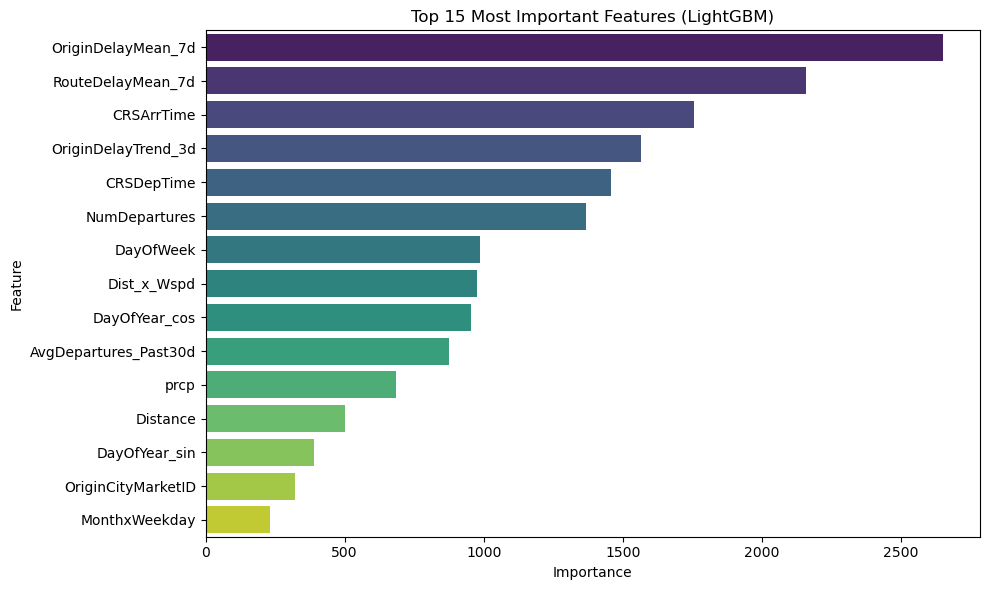

In [ ]:
# =========================
# Train LightGBM
# =========================
best_params = study.best_params
lgb = lgbm(**best_params)

lgb.fit(X_train, y_train)

# =========================
# Predict, back-transform, and evaluate
# =========================

y_pred_log = lgb.predict(X_test)
y_pred = np.expm1(y_pred_log)       # back to minutes
y_test_original = np.expm1(y_test)  # back to minutes

# Evaluate in log space
mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)

# Evaluate in original minutes
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print("\nModel Performance (LightGBM):")
print("\nIn Log Space:")
print(f"R²:  {r2_log:.4f}")
print("\nIn Original Minutes:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# =========================
# Feature importance plot
# =========================
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis', legend=False)
plt.title("Top 15 Most Important Features (LightGBM)")
plt.tight_layout()
plt.show()

### Random Forest

In [ ]:
# Select relevant numeric features
features = df.columns.tolist()
features.remove('DepDelayMinutes')

# One-hot encode categorical variables
one_hot_cols = [col for col in df.columns if col.startswith('Origin_') or col.startswith('Month_') or col.startswith('DayOfWeek_') or col.startswith('Dest_')]

# Target variable
target = 'DepDelayMinutes'

# Define X and y
X = df[features + one_hot_cols]
y = df[target]

X_sample = X.sample(500_000, random_state = 42)
y_sample = y.loc[X_sample.index]

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# =========================
# 5️⃣ Train Random Forest
# =========================
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1
)
rf.fit(X_train, y_train)

# =========================
# 6️⃣ Evaluate model
# =========================
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Model Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

# =========================
# 7️⃣ Feature importance plot
# =========================
importances = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')
plt.title("Top 15 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()

TypeError: Cannot cast DatetimeArray to dtype float32